In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [4]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_14_modif_top10ventas_nov.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

,CodigoSucursal,CodigoDepartamento,CodigoEstado,TipoMovimiento,DescripcionMovimiento,NumeroMovimiento,NumeroCorrelativo,FechaMovimiento,NombreProducto,UnidadMedida,CantidadSalida,PesoSalida,MontoBase,PrecioUnitario,CostoUnitario,MontoReferencia,NombreGrupo
0,14,1,AC,SVE,VENTA COMPUTARIZADA,18110090,0,2018-11-02 08:19:14,POLLO CON MENUDENCIA H-C,KG,0.0000,5.5367,63.6350,10.2350,10.2350,9.1430,FAENEADO
1,14,1,AC,SVE,VENTA COMPUTARIZADA,18110164,1,2018-11-03 07:46:01,POLLO CON MENUDENCIA H-C,KG,0.0000,9.4340,108.4910,10.2350,10.2350,15.5875,FAENEADO
2,14,1,AC,SVE,VENTA COMPUTARIZADA,18110173,0,2018-11-03 08:09:25,POLLO CON MENUDENCIA H-C,KG,0.0000,1.8005,20.7370,10.2350,10.2350,2.9797,FAENEADO
3,14,1,AC,SVE,VENTA COMPUTARIZADA,18110174,0,2018-11-03 08:17:04,POLLO CON MENUDENCIA H-C,KG,0.0000,5.4682,62.9230,10.2350,10.2350,9.0406,FAENEADO
4,14,1,AC,SVE,VENTA COMPUTARIZADA,18110175,0,2018-11-03 08:19:38,POLLO CON MENUDENCIA H-C,KG,0.0000,1.8592,21.3600,10.2350,10.2350,3.0687,FAENEADO


In [5]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [6]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

In [7]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-7-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


In [8]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_todo[(df_todo['FechaMovimiento'] >= '2023-11-01') & (df_todo['FechaMovimiento'] <= '2023-12-01')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_todo[df_todo['FechaMovimiento'] < '2023-11-01']

df_todo = df_todo[df_todo['FechaMovimiento'] < '2023-12-01']

In [9]:
print("todo ", df_todo.shape)
print("sin noviembre ", df_todo_hasta_nov.shape)
print("noviembre 2023 ", df_noviembre.shape)

todo  (121359, 4)
sin noviembre  (119577, 4)
noviembre 2023  (1782, 4)


In [10]:
df_noviembre.head()

,NombreProducto,FechaMovimiento,MontoBase,year
106785,MUSLO,2023-11-01 08:06:19,121.6056,2023
26139,POLLO SIN MENUDENCIA H-C,2023-11-01 08:07:30,30.3045,2023
86040,PECHUGA,2023-11-01 08:15:50,11.7576,2023
106786,MUSLO,2023-11-01 08:15:50,42.9088,2023
86041,PECHUGA,2023-11-01 08:17:03,28.8880,2023


In [11]:
df_noviembre.tail()

,NombreProducto,FechaMovimiento,MontoBase,year
86434,PECHUGA,2023-11-30 12:27:48,87.2068,2023
26524,POLLO SIN MENUDENCIA H-C,2023-11-30 12:34:59,2582.7177,2023
41542,POLLO ESPECIAL,2023-11-30 12:39:38,684.8550,2023
26525,POLLO SIN MENUDENCIA H-C,2023-11-30 12:40:34,403.0543,2023
26526,POLLO SIN MENUDENCIA H-C,2023-11-30 12:42:24,1225.8415,2023


In [12]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
print("\n\n")

In [13]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_suma_sin_2020 = df_noviembre_sumaT.copy()

      FechaMovimiento  MontoBase
0 2023-11-01 08:06:19   121.6056
1 2023-11-01 08:07:30    30.3045
2 2023-11-01 08:15:50    54.6664
3 2023-11-01 08:17:03    28.8880
4 2023-11-01 08:17:54     5.5016
5 2023-11-01 08:22:37    37.9684
6 2023-11-01 08:26:10    30.3757
7 2023-11-01 08:28:25    28.0528
8 2023-11-01 08:44:38    78.9268
9 2023-11-01 08:46:27    31.3725
FechaMovimiento    datetime64[ns]
MontoBase                 float64
dtype: object
(1330, 2)


# PROPHET


### Preparado de los DataFrame

In [14]:
## Sumar las ventas por día en df_noviembre
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
# se suman todas las ventas por dia
df_noviembre_prophet = df_noviembre.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

df_noviembre_prophet = df_noviembre_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo_hasta_nov_prophet = df_todo_hasta_nov_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)
print("----Prophet----")
print(df_noviembre_prophet.head)
print(df_noviembre_prophet.dtypes)
print(df_todo_hasta_nov_prophet.head)
print(df_todo_hasta_nov_prophet.dtypes)

<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase  year
106785                     MUSLO      2023-11-01   121.6056  2023
26139   POLLO SIN MENUDENCIA H-C      2023-11-01    30.3045  2023
86040                    PECHUGA      2023-11-01    11.7576  2023
106786                     MUSLO      2023-11-01    42.9088  2023
86041                    PECHUGA      2023-11-01    28.8880  2023
...                          ...             ...        ...   ...
86434                    PECHUGA      2023-11-30    87.2068  2023
26524   POLLO SIN MENUDENCIA H-C      2023-11-30  2582.7177  2023
41542             POLLO ESPECIAL      2023-11-30   684.8550  2023
26525   POLLO SIN MENUDENCIA H-C      2023-11-30   403.0543  2023
26526   POLLO SIN MENUDENCIA H-C      2023-11-30  1225.8415  2023

[1782 rows x 4 columns]>
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
<bound method NDFrame.head of 

In [15]:
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])

df_todo_hasta_nov_sin_2020 = df_todo_hasta_nov[~(df_todo_hasta_nov['FechaMovimiento'].dt.year == 2020)]

print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov_sin_2020.head())
print(df_todo_hasta_nov_sin_2020.dtypes)

# se devuelve el tipo object a ds para prophet
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
df_todo_hasta_nov_sin_2020['FechaMovimiento'] = df_todo_hasta_nov_sin_2020['FechaMovimiento'].dt.date

print("---" *10)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print(df_todo_hasta_nov_sin_2020.head())
print(df_todo_hasta_nov_sin_2020.dtypes)
print(df_todo_hasta_nov_sin_2020.shape)

NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
NombreProducto             object
FechaMovimiento    datetime64[ns]
MontoBase                 float64
year                        int64
dtype: object
         NombreProducto FechaMovimiento  MontoBase  year
86435    PECHUGA OFERTA      2018-11-01    15.5480  2018
106928  FILETE A GRANEL      2018-11-01    19.9640  2018
26566    POLLO ESPECIAL      2018-11-01    18.6900  2018
106929  FILETE A GRANEL      2018-11-01    19.9640  2018
26567    POLLO ESPECIAL      2018-11-01    19.4020  2018
NombreProducto             object
FechaMovimiento    datetime64[ns]
MontoBase                 float64
year                        int64
dtype: object
------------------------------
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
ye

<ipython-input-15-9da9706da809>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo_hasta_nov_sin_2020['FechaMovimiento'] = df_todo_hasta_nov_sin_2020['FechaMovimiento'].dt.date


In [16]:
# #primero cambiamos la columna ds a datatime
# df_noviembre['ds'] = pd.to_datetime(df_noviembre['ds'])
# df_todo_hasta_nov['ds'] = pd.to_datetime(df_todo_hasta_nov['ds'])
# # se quitan las horas de la columna de tiempo
# df_noviembre['ds'] = df_noviembre['ds'].dt.date
# df_todo_hasta_nov['ds'] = df_todo_hasta_nov['ds'].dt.date
# se suman todas las ventas por dia

df_todo_hasta_nov_sin_2020_prophet = df_todo_hasta_nov_sin_2020.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_sin_2020_prophet = df_todo_hasta_nov_sin_2020_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_todo_hasta_nov_sin_2020_prophet.head)
print(df_todo_hasta_nov_sin_2020_prophet.shape)

<bound method NDFrame.head of               ds         y
0     2018-11-01 1475.2840
1     2018-11-02 2284.0240
2     2018-11-03 2621.9550
3     2018-11-04 4610.9490
4     2018-11-05 2468.8390
...          ...       ...
1412  2023-10-27 8692.4340
1413  2023-10-28 2662.3572
1414  2023-10-29 5225.2595
1415  2023-10-30 3387.6399
1416  2023-10-31 2956.2879

[1417 rows x 2 columns]>
(1417, 2)


### Creacion de objetos que contienen 10 DF c/u con los productos mas vendidos

In [17]:
# # Obtener los 10 productos más vendidos
# top_10_products = df['NombreProducto'].value_counts().head(10).index

# # Crear un diccionario para almacenar los DataFrames divididos
# dfs_de_productos = {}
# dfs_de_productos_sin_2020 = {}

# # Iterar sobre los productos y dividir el DataFrame
# for product in top_10_products:
#     # Crear un DataFrame para el producto actual
#     product_df = df_todo[df_todo['NombreProducto'] == product].copy()
#     product_df_sin_2020 = df_todo_hasta_nov_sin_2020[df_todo_hasta_nov_sin_2020['NombreProducto'] == product].copy()

#     # Opcional: Puedes establecer la columna de fecha como índice si es relevante para tus análisis
#     # product_df.set_index('FechaMovimiento', inplace=True)
#     # product_df_sin_2020.set_index('FechaMovimiento', inplace=True)
#     product_df.set_index('FechaMovimiento', inplace=True)
#     product_df_sin_2020.set_index('FechaMovimiento', inplace=True)


#     # Almacenar el DataFrame en el diccionario
#     dfs_de_productos[product] = product_df
#     dfs_de_productos_sin_2020[product] = product_df_sin_2020

# # Ahora, dfs_by_product contiene 10 DataFrames, uno por cada producto
# # Puedes acceder a un DataFrame específico utilizando su nombre de producto como clave
# # Por ejemplo, dfs_by_product['Nombre_Producto_1']

In [18]:
# print(dfs_de_productos)

In [19]:
# print(dfs_de_productos_sin_2020)

In [20]:
# unique_products = df['NombreProducto'].unique()
# print(unique_products)

In [21]:
# for i, df_product in enumerate(dfs_de_productos):
#     print(f"DataFrame {i + 1} - Tipos de Datos:")
#     print(dfs_de_productos[df_product].dtypes)
#     print("=" * 30)

## Predecir cada uno de los 10 productos mas vendidos

In [22]:
# # Crear un diccionario para almacenar las predicciones
# predicciones_por_producto = {}

# # Seleccionar el rango de fechas que quieres mostrar (últimos 2-3 meses)
# fecha_inicio_str = '2023-09-01'  # Ajusta según tus necesidades
# fecha_fin_str = '2023-11-30'    # Ajusta según tus necesidades
# # Convertir las fechas a objetos datetime
# fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
# fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# # Iterar sobre los DataFrames de productos y aplicar Prophet
# for product, product_df in dfs_de_productos.items():
#     # Restaurar el índice para asegurarse de que 'ds' sea una columna
#     product_df.reset_index(inplace=True)

#     # Crear y ajustar el modelo de Prophet
#     modelo = Prophet()
#     modelo.fit(product_df)

#     # Crear un DataFrame con fechas futuras para hacer la predicción
#     futuro = modelo.make_future_dataframe(periods=30)  # Asumiendo que quieres prever 30 días adicionales

#     # Hacer la predicción
#     prediccion = modelo.predict(futuro)

#     # Almacenar la predicción en el diccionario
#     predicciones_por_producto[product] = prediccion


# # Visualizar la predicción con límites ajustados
#     fig = modelo.plot(prediccion)
# # Aplicar límites al eje x
#     plt.xlim([fecha_inicio, fecha_fin])
# # Añadir título al gráfico
#     plt.title(f'Predicción de Ventas para {product} (Últimos 2-3 meses y Predicción de 30 días)')
# # Mostrar el gráfico
#     plt.show()

#     # # Visualizar la predicción
#     # fig = modelo.plot(prediccion)
#     # plt.title(f'Predicción de Ventas para {product}')
#     # plt.show()

In [23]:
# # Crear un diccionario para almacenar las predicciones
# predicciones_por_producto = {}


# # Seleccionar el rango de fechas que quieres mostrar (últimos 2-3 meses)
# fecha_inicio_str = '2023-09-01'  # Ajusta según tus necesidades
# fecha_fin_str = '2023-11-30'    # Ajusta según tus necesidades
# # Convertir las fechas a objetos datetime
# fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
# fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')


# # Iterar sobre los DataFrames de productos y aplicar Prophet
# for product, product_df in dfs_de_productos_sin_2020.items():
#     # Restaurar el índice para asegurarse de que 'ds' sea una columna
#     product_df.reset_index(inplace=True)

#     # Crear y ajustar el modelo de Prophet
#     modelo = Prophet()
#     modelo.fit(product_df)

#     # Crear un DataFrame con fechas futuras para hacer la predicción
#     futuro = modelo.make_future_dataframe(periods=30)  # Asumiendo que quieres prever 30 días adicionales

#     # Hacer la predicción
#     prediccion = modelo.predict(futuro)

#     # Almacenar la predicción en el diccionario
#     predicciones_por_producto[product] = prediccion

# # Visualizar la predicción con límites ajustados
#     fig = modelo.plot(prediccion)
# # Aplicar límites al eje x
#     plt.xlim([fecha_inicio, fecha_fin])
# # Añadir título al gráfico
#     plt.title(f'Predicción de Ventas para {product} (Últimos 2-3 meses y Predicción de 30 días)')
# # Mostrar el gráfico
#     plt.show()

#     # # Visualizar la predicción
#     # fig = modelo.plot(prediccion)
#     # plt.title(f'Predicción de Ventas para {product}')
#     # plt.show()

## Predicciones con y sin 2020 de los 10 productos más vendidos

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjow95rpn/7elh5ijc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjow95rpn/xk5sh6w_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82225', 'data', 'file=/tmp/tmpjow95rpn/7elh5ijc.json', 'init=/tmp/tmpjow95rpn/xk5sh6w_.json', 'output', 'file=/tmp/tmpjow95rpn/prophet_modela9qr5gf0/prophet_model-20240222182951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjo

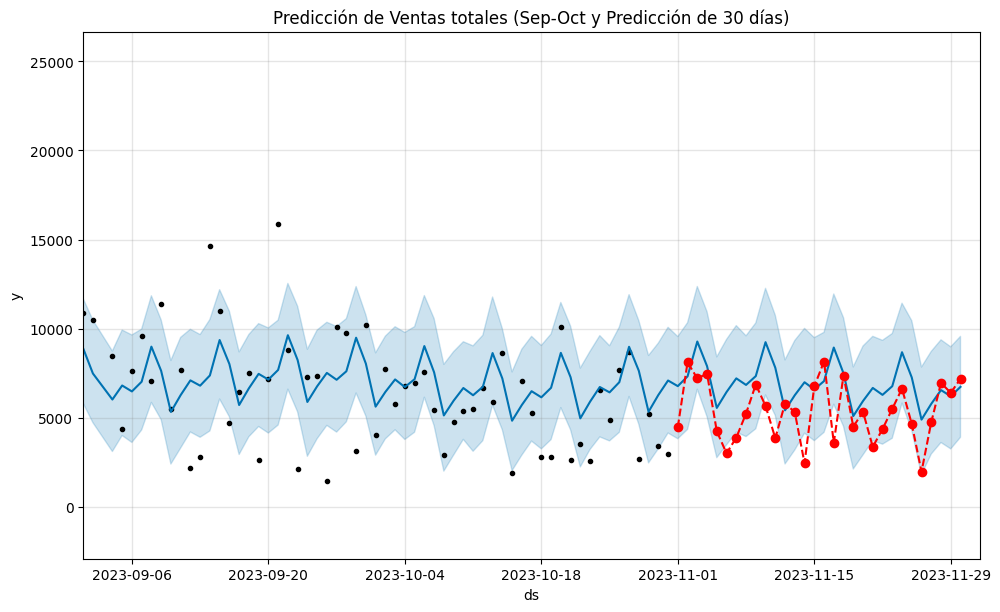

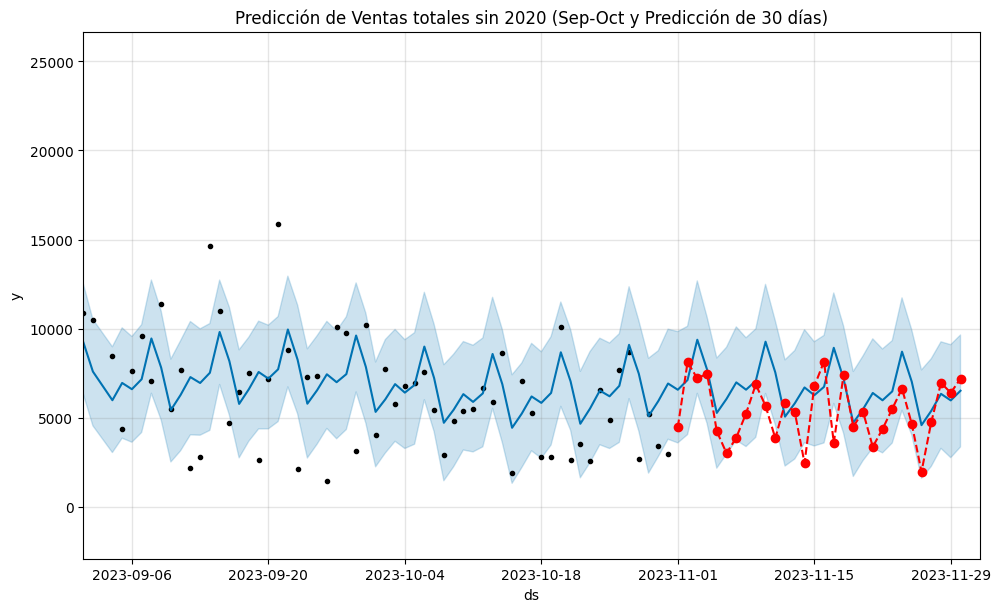

prediccion con todos los valores               ds      yhat
1717 2023-11-01 6767.3108
1718 2023-11-02 7314.8346
1719 2023-11-03 9272.4877
1720 2023-11-04 7889.3505
1721 2023-11-05 5544.5831
1722 2023-11-06 6436.9181
1723 2023-11-07 7203.7810
1724 2023-11-08 6835.5754
1725 2023-11-09 7330.5173
1726 2023-11-10 9236.0115
1727 2023-11-11 7802.3071
1728 2023-11-12 5409.6706
1729 2023-11-13 6257.8539
1730 2023-11-14 6985.1935
1731 2023-11-15 6582.8769
1732 2023-11-16 7049.7622
1733 2023-11-17 8933.7437
1734 2023-11-18 7485.4003
1735 2023-11-19 5085.1662
1736 2023-11-20 5932.8000
1737 2023-11-21 6666.4891
1738 2023-11-22 6277.1254
1739 2023-11-23 6763.1367
1740 2023-11-24 8671.8679
1741 2023-11-25 7253.2468
1742 2023-11-26 4886.9742
1743 2023-11-27 5772.0135
1744 2023-11-28 6545.7171
1745 2023-11-29 6198.1228
1746 2023-11-30 6726.8069
prediccion sin el 2020               ds      yhat
1417 2023-11-01 6562.2419
1418 2023-11-02 7110.2903
1419 2023-11-03 9370.8507
1420 2023-11-04 7698.7312
1421 2

In [24]:
# definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'
# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# Crear un modelo de Prophet
modelo1 = Prophet()
modelo2 = Prophet()
# Ajustar el modelo con los datos de entrenamiento
modelo1.fit(df_todo_hasta_nov_prophet)
modelo2.fit(df_todo_hasta_nov_sin_2020_prophet)
# Crear un DataFrame con fechas futuras para hacer la predicción
futuro1 = modelo1.make_future_dataframe(periods=30)
futuro2 = modelo2.make_future_dataframe(periods=30)
# Hacer la predicción
prediccion1 = modelo1.predict(futuro1)
prediccion2 = modelo2.predict(futuro2)

# Visualizar la predicción con límites ajustados
fig = modelo1.plot(prediccion1)

plt.plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')

# Aplicar límites al eje x
plt.xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
plt.title(f'Predicción de Ventas totales (Sep-Oct y Predicción de 30 días)')
# Mostrar el gráfico
plt.show()

# Visualizar la predicción con límites ajustados
fig = modelo2.plot(prediccion2)

plt.plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')

# Aplicar límites al eje x
plt.xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
plt.title(f'Predicción de Ventas totales sin 2020 (Sep-Oct y Predicción de 30 días)')
# Mostrar el gráfico
plt.show()


# Extraer los valores reales de predicción para cada día
valores_prediccion1 = prediccion1[['ds', 'yhat']].tail(30)
valores_prediccion2 = prediccion2[['ds', 'yhat']].tail(30)

# Mostrar el DataFrame con los valores de predicción
print("prediccion con todos los valores " , valores_prediccion1)
print("prediccion sin el 2020 " , valores_prediccion2)
# # Visualizar la predicción
# fig = modelo1.plot(prediccion1)
# plt.show()

# fig = modelo2.plot(prediccion2)
# plt.show()

## EVALUACION
Predicciones hechas sobre todas las ventas de los 10 producton contando con y sin las ventas de 2020

evaluacion con 2020

In [25]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_suma_sin_2020 = df_noviembre_sumaT.copy()

  FechaMovimiento  MontoBase
0      2023-11-01  4462.3058
1      2023-11-02  8102.9741
2      2023-11-03  7202.3021
3      2023-11-04  7468.0628
4      2023-11-05  4232.6536
5      2023-11-06  2994.0749
6      2023-11-07  3876.1407
7      2023-11-08  5228.0023
8      2023-11-09  6858.0460
9      2023-11-10  5662.3457
FechaMovimiento     object
MontoBase          float64
dtype: object
(30, 2)


In [26]:
# print(valores_prediccion1.describe)
# print(df_noviembre_sumaT.shape)

In [27]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_sumaT['FechaMovimiento'] = pd.to_datetime(df_noviembre_sumaT['FechaMovimiento'])
valores_prediccion1['ds'] = pd.to_datetime(valores_prediccion1['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_sumaT = pd.merge(df_noviembre_sumaT, valores_prediccion1[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_sumaT.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_sumaT.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_sumaT.head(50))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  4462.3058       6767.3108
1       2023-11-02  8102.9741       7314.8346
2       2023-11-03  7202.3021       9272.4877
3       2023-11-04  7468.0628       7889.3505
4       2023-11-05  4232.6536       5544.5831
5       2023-11-06  2994.0749       6436.9181
6       2023-11-07  3876.1407       7203.7810
7       2023-11-08  5228.0023       6835.5754
8       2023-11-09  6858.0460       7330.5173
9       2023-11-10  5662.3457       9236.0115
10      2023-11-11  3842.8728       7802.3071
11      2023-11-12  5791.7782       5409.6706
12      2023-11-13  5310.8120       6257.8539
13      2023-11-14  2437.4624       6985.1935
14      2023-11-15  6755.3347       6582.8769
15      2023-11-16  8146.9736       7049.7622
16      2023-11-17  3588.5367       8933.7437
17      2023-11-18  7364.5864       7485.4003
18      2023-11-19  4492.4805       5085.1662
19      2023-11-20  5327.1019       5932.8000
20      2023-11-21  3356.9386     

In [28]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])

Evaluation metric results:-
MSE is : 5194874.530542092
MAE is : 1775.2011151021725
R2 is : -0.894602907993103 %
------------------------------
RMSE is : 2279.2267396075567
MAPE is : 45.758223365531215 %
------------------------------


evaluacion sin 2020

In [29]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_suma_sin_2020['FechaMovimiento'] = pd.to_datetime(df_noviembre_suma_sin_2020['FechaMovimiento'])
valores_prediccion2['ds'] = pd.to_datetime(valores_prediccion2['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_suma_sin_2020 = pd.merge(df_noviembre_suma_sin_2020, valores_prediccion2[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_suma_sin_2020.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_suma_sin_2020.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_suma_sin_2020.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  4462.3058       6562.2419
1       2023-11-02  8102.9741       7110.2903
2       2023-11-03  7202.3021       9370.8507
3       2023-11-04  7468.0628       7698.7312
4       2023-11-05  4232.6536       5260.5752
5       2023-11-06  2994.0749       6049.3674
6       2023-11-07  3876.1407       6976.0248
7       2023-11-08  5228.0023       6566.2572
8       2023-11-09  6858.0460       7055.8932
9       2023-11-10  5662.3457       9260.5922
10      2023-11-11  3842.8728       7536.4184
11      2023-11-12  5791.7782       5051.1485
12      2023-11-13  5310.8120       5798.7520
13      2023-11-14  2437.4624       6690.9614
14      2023-11-15  6755.3347       6254.1165
15      2023-11-16  8146.9736       6724.4794
16      2023-11-17  3588.5367       8917.9405
17      2023-11-18  7364.5864       7190.5926
18      2023-11-19  4492.4805       4710.0431
19      2023-11-20  5327.1019       5469.9049


In [30]:
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_PROPHET'])

Evaluation metric results:-
MSE is : 4636677.215003964
MAE is : 1660.041402236565
R2 is : -0.691024890654131 %
------------------------------
RMSE is : 2153.2945026177827
MAPE is : 42.192873622065605 %
------------------------------


# LSTM


In [31]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [32]:
print(df_todo_hasta_nov.head())
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print("---"*5, "  PROPHET  ", "---"*5)
print(df_todo_hasta_nov_prophet.head())
print(df_todo_hasta_nov_prophet.dtypes)
print(df_todo_hasta_nov_prophet.shape)

         NombreProducto FechaMovimiento  MontoBase  year
86435    PECHUGA OFERTA      2018-11-01    15.5480  2018
106928  FILETE A GRANEL      2018-11-01    19.9640  2018
26566    POLLO ESPECIAL      2018-11-01    18.6900  2018
106929  FILETE A GRANEL      2018-11-01    19.9640  2018
26567    POLLO ESPECIAL      2018-11-01    19.4020  2018
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
(119577, 4)
---------------   PROPHET   ---------------
           ds         y
0  2018-11-01 1475.2840
1  2018-11-02 2284.0240
2  2018-11-03 2621.9550
3  2018-11-04 4610.9490
4  2018-11-05 2468.8390
ds     object
y     float64
dtype: object
(1717, 2)


In [33]:
df_lstm = df_todo_hasta_nov_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })

df_lstm_sin_2020 = df_todo_hasta_nov_sin_2020_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })

In [34]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm = df_lstm[['FechaMovimiento', 'MontoBase']]
df_lstm['FechaMovimiento'] = pd.to_datetime(df_lstm['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm.set_index('FechaMovimiento', inplace=True)

# Preprocesamiento de fechas utilizando el índice
df_lstm['DayOW'] = df_lstm.index.dayofweek
df_lstm['Month'] = df_lstm.index.month
df_lstm['Year'] = df_lstm.index.year

# Ordenar el DataFrame por la fecha
df_lstm.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm)

                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-01       1475.2840      3     11  2018
2018-11-02       2284.0240      4     11  2018
2018-11-03       2621.9550      5     11  2018
2018-11-04       4610.9490      6     11  2018
2018-11-05       2468.8390      0     11  2018
...                    ...    ...    ...   ...
2023-10-27       8692.4340      4     10  2023
2023-10-28       2662.3572      5     10  2023
2023-10-29       5225.2595      6     10  2023
2023-10-30       3387.6399      0     10  2023
2023-10-31       2956.2879      1     10  2023

[1717 rows x 4 columns]


In [35]:
print(df_lstm)
print(df_lstm.dtypes)
print(df_todo_hasta_nov_prophet)
print(df_todo_hasta_nov_prophet.dtypes)

                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-01       1475.2840      3     11  2018
2018-11-02       2284.0240      4     11  2018
2018-11-03       2621.9550      5     11  2018
2018-11-04       4610.9490      6     11  2018
2018-11-05       2468.8390      0     11  2018
...                    ...    ...    ...   ...
2023-10-27       8692.4340      4     10  2023
2023-10-28       2662.3572      5     10  2023
2023-10-29       5225.2595      6     10  2023
2023-10-30       3387.6399      0     10  2023
2023-10-31       2956.2879      1     10  2023

[1717 rows x 4 columns]
MontoBase    float64
DayOW          int64
Month          int64
Year           int64
dtype: object
              ds         y
0     2018-11-01 1475.2840
1     2018-11-02 2284.0240
2     2018-11-03 2621.9550
3     2018-11-04 4610.9490
4     2018-11-05 2468.8390
...          ...       ...
1712  2023-10-27 8692.4340
1713  2023-10-28 2662.3572
1714  2023-10-29 5225.2

In [36]:
# print(df_todo.tail(30))
# df_todo.sort_values(by='ds', inplace=True)
# print(df_todo.tail(20))

# Verificar unicidad de fechas
duplicates = df_lstm.index[df_lstm.index.duplicated(keep=False)]
if len(duplicates) > 0:
    print("Hay fechas duplicadas en df_lstm:")
    print(duplicates)
else:
    print("No hay fechas duplicadas en df_lstm.")

No hay fechas duplicadas en df_lstm.


In [37]:
df_lstm.describe()
#df_lstm.head

,MontoBase,DayOW,Month,Year
count,1717.0000,1717.0000,1717.0000,1717.0000
mean,5123.8273,2.8870,6.5463,2020.8695
std,2860.9934,1.9638,3.4887,1.4855
min,11.1872,0.0000,1.0000,2018.0000
25%,3235.0670,1.0000,3.0000,2020.0000
50%,4398.6670,3.0000,7.0000,2021.0000
75%,6083.5753,5.0000,10.0000,2022.0000
max,25309.9626,6.0000,12.0000,2023.0000


In [38]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm['MontoBase_scaler'] = scaler.fit_transform(df_lstm['MontoBase'].values.reshape(-1, 1))

# Crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences(df_lstm['MontoBase_scaler'].values, seq_length)


dividir en entrenamiento y al final toda la prueba

In [39]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dividir en periodos de testeo en medio de la serie temporal

In [40]:
# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [41]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Desnormalizar las predicciones
predictions = scaler.inverse_transform(predictions)


Epoch 1/50
43/43 - 3s - loss: 0.0127 - 3s/epoch - 78ms/step
Epoch 2/50
43/43 - 1s - loss: 0.0094 - 531ms/epoch - 12ms/step
Epoch 3/50
43/43 - 1s - loss: 0.0094 - 504ms/epoch - 12ms/step
Epoch 4/50
43/43 - 1s - loss: 0.0094 - 536ms/epoch - 12ms/step
Epoch 5/50
43/43 - 1s - loss: 0.0095 - 511ms/epoch - 12ms/step
Epoch 6/50
43/43 - 1s - loss: 0.0092 - 517ms/epoch - 12ms/step
Epoch 7/50
43/43 - 1s - loss: 0.0093 - 511ms/epoch - 12ms/step
Epoch 8/50
43/43 - 1s - loss: 0.0091 - 520ms/epoch - 12ms/step
Epoch 9/50
43/43 - 1s - loss: 0.0091 - 504ms/epoch - 12ms/step
Epoch 10/50
43/43 - 1s - loss: 0.0092 - 530ms/epoch - 12ms/step
Epoch 11/50
43/43 - 1s - loss: 0.0090 - 504ms/epoch - 12ms/step
Epoch 12/50
43/43 - 1s - loss: 0.0090 - 527ms/epoch - 12ms/step
Epoch 13/50
43/43 - 1s - loss: 0.0091 - 503ms/epoch - 12ms/step
Epoch 14/50
43/43 - 1s - loss: 0.0091 - 515ms/epoch - 12ms/step
Epoch 15/50
43/43 - 1s - loss: 0.0089 - 583ms/epoch - 14ms/step
Epoch 16/50
43/43 - 1s - loss: 0.0091 - 813ms/epoch 

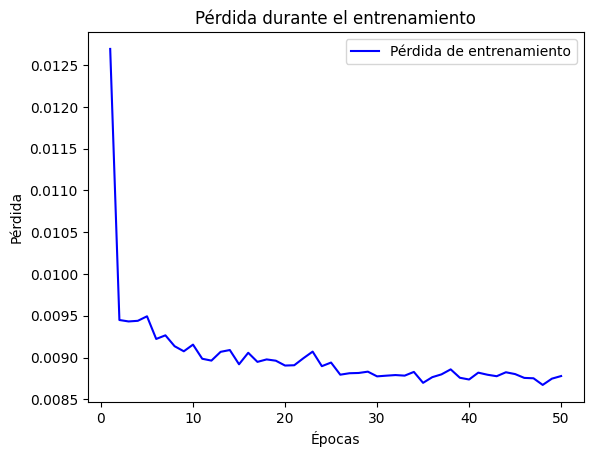

In [42]:
# Recuperar la función de pérdida durante el entrenamiento
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Graficar la pérdida durante el entrenamiento
plt.plot(epochs, loss, 'b', label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Error cuadrático medio en el conjunto de prueba: 8269001.473912184


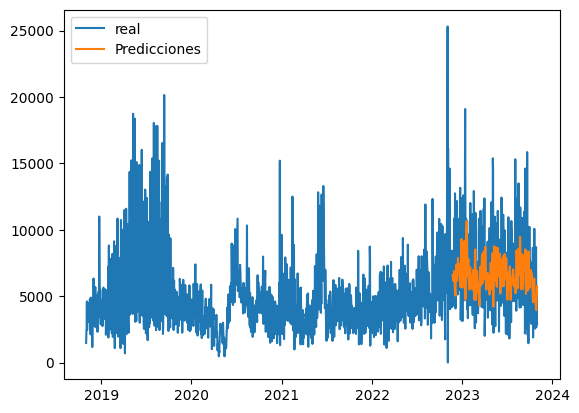

In [43]:
# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(df_lstm['MontoBase'].values[train_size+seq_length:], predictions)
print(f"Error cuadrático medio en el conjunto de prueba: {mse}")

# Visualizar las predicciones
plt.plot(df_lstm['MontoBase'], label='real')
plt.plot(df_lstm.index[train_size+seq_length:], predictions, label='Predicciones')
plt.legend()
plt.show()

In [44]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (1687, 30)
Forma de y: (1687, 1)


1/1 [==============================] - 0s 22ms/step


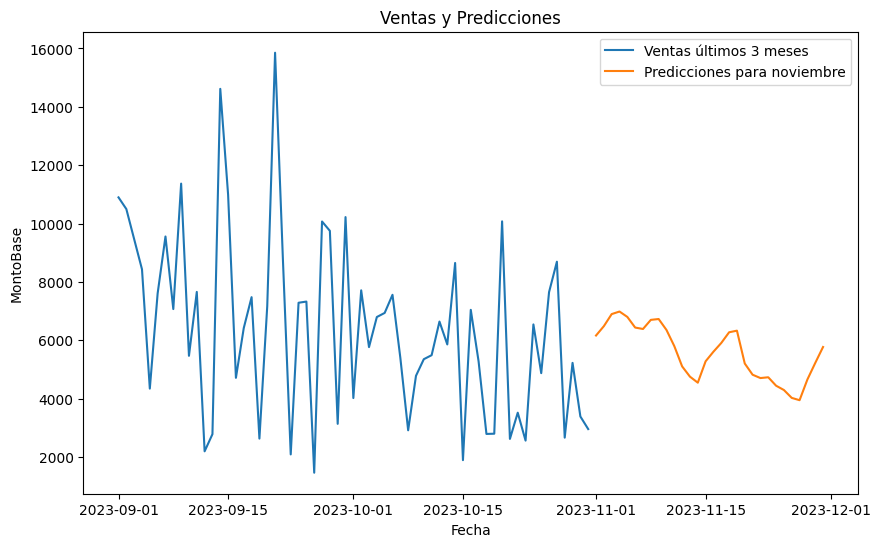

In [45]:
# Supongamos que df_lstm tiene la columna 'FechaMovimiento' como índice
df_lstm.index = pd.to_datetime(df_lstm.index)

# Paso 1: Preparar datos de entrada para las predicciones
last_3_months = df_lstm[df_lstm.index >= '2023-09-01']  # Ajusta la fecha según tu necesidad
input_data = last_3_months['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences(input_data, seq_length)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Paso 2: Hacer predicciones para los siguientes 30 días
predictions_future = model.predict(input_data)

# Desnormalizar las predicciones
predictions_future = scaler.inverse_transform(predictions_future)

# Paso 3: Visualizar los resultados
plt.figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plt.plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
plt.plot(dates_future, predictions_future, label='Predicciones para noviembre')

plt.title('Ventas y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('MontoBase')
plt.legend()
plt.show()

### Evaluar

In [46]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_LSTM'] = predictions_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  4462.3058       6767.3108    6162.8828
1       2023-11-02  8102.9741       7314.8346    6483.5054
2       2023-11-03  7202.3021       9272.4877    6897.1533
3       2023-11-04  7468.0628       7889.3505    6985.0259
4       2023-11-05  4232.6536       5544.5831    6799.6948
5       2023-11-06  2994.0749       6436.9181    6435.5767
6       2023-11-07  3876.1407       7203.7810    6387.0767
7       2023-11-08  5228.0023       6835.5754    6699.1777
8       2023-11-09  6858.0460       7330.5173    6728.2056
9       2023-11-10  5662.3457       9236.0115    6352.9175
10      2023-11-11  3842.8728       7802.3071    5799.1196
11      2023-11-12  5791.7782       5409.6706    5103.9419
12      2023-11-13  5310.8120       6257.8539    4752.3149
13      2023-11-14  2437.4624       6985.1935    4546.6108
14      2023-11-15  6755.3347       6582.8769    5279.9849
15      2023-11-16  8146.9736       7049.7622    5608.63

In [47]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:-
MSE is : 2737667.5119764977
MAE is : 1415.3513227994795
R2 is : 0.001555706723167516 %
------------------------------
RMSE is : 1654.5898319452158
MAPE is : 32.86720059165147 %
------------------------------


## SIN 2020

In [48]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm_sin_2020 = df_lstm_sin_2020[['FechaMovimiento', 'MontoBase']]
df_lstm_sin_2020['FechaMovimiento'] = pd.to_datetime(df_lstm_sin_2020['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm_sin_2020.set_index('FechaMovimiento', inplace=True)

# Preprocesamiento de fechas utilizando el índice
df_lstm_sin_2020['DayOW'] = df_lstm_sin_2020.index.dayofweek
df_lstm_sin_2020['Month'] = df_lstm_sin_2020.index.month
df_lstm_sin_2020['Year'] = df_lstm_sin_2020.index.year

# Ordenar el DataFrame por la fecha
df_lstm_sin_2020.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm_sin_2020)

# Normalizar los datos
scaler_2 = MinMaxScaler(feature_range=(0, 1))
df_lstm_sin_2020['MontoBase_scaler'] = scaler_2.fit_transform(df_lstm_sin_2020['MontoBase'].values.reshape(-1, 1))

# Crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences(df_lstm_sin_2020['MontoBase_scaler'].values, seq_length)


# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construir el modelo LSTM
model_2 = Sequential()
model_2.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Hacer predicciones en el conjunto de prueba
predictions_2 = model_2.predict(X_test)

# Desnormalizar las predicciones
predictions_2 = scaler_2.inverse_transform(predictions_2)


                 MontoBase  DayOW  Month  Year
FechaMovimiento                               
2018-11-01       1475.2840      3     11  2018
2018-11-02       2284.0240      4     11  2018
2018-11-03       2621.9550      5     11  2018
2018-11-04       4610.9490      6     11  2018
2018-11-05       2468.8390      0     11  2018
...                    ...    ...    ...   ...
2023-10-27       8692.4340      4     10  2023
2023-10-28       2662.3572      5     10  2023
2023-10-29       5225.2595      6     10  2023
2023-10-30       3387.6399      0     10  2023
2023-10-31       2956.2879      1     10  2023

[1417 rows x 4 columns]
Epoch 1/50
35/35 - 2s - loss: 0.0211 - 2s/epoch - 68ms/step
Epoch 2/50
35/35 - 0s - loss: 0.0118 - 437ms/epoch - 12ms/step
Epoch 3/50
35/35 - 0s - loss: 0.0113 - 403ms/epoch - 12ms/step
Epoch 4/50
35/35 - 0s - loss: 0.0111 - 425ms/epoch - 12ms/step
Epoch 5/50
35/35 - 0s - loss: 0.0110 - 414ms/epoch - 12ms/step
Epoch 6/50
35/35 - 0s - loss: 0.0114 - 411ms/epoch -

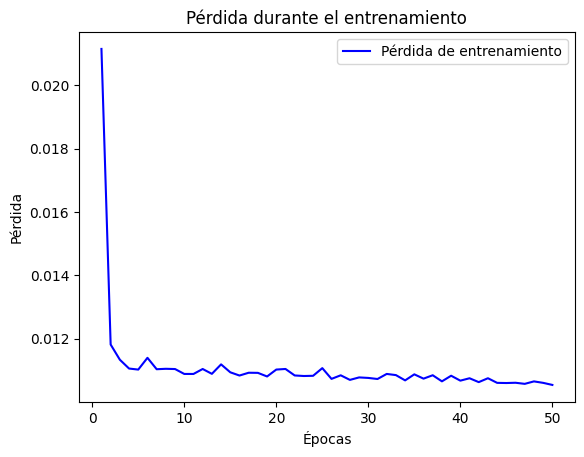

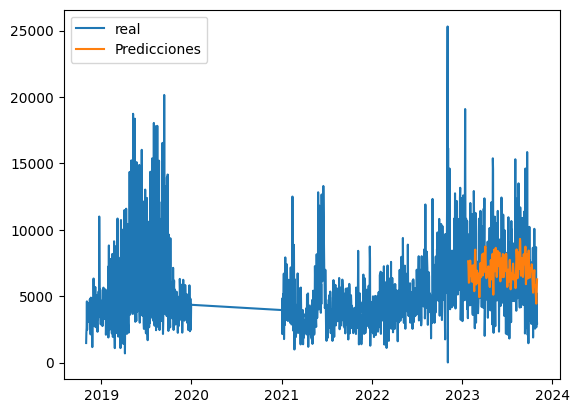

In [49]:
# Recuperar la función de pérdida durante el entrenamiento
loss_2 = history_2.history['loss']
epochs_2 = range(1, len(loss_2) + 1)

# Graficar la pérdida durante el entrenamiento
plt.plot(epochs_2, loss_2, 'b', label='Pérdida de entrenamiento')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


# Visualizar las predicciones
plt.plot(df_lstm_sin_2020['MontoBase'], label='real')
plt.plot(df_lstm_sin_2020.index[train_size+seq_length:], predictions_2, label='Predicciones')
plt.legend()
plt.show()


Forma de X: (1387, 30)
Forma de y: (1387, 1)
1/1 [==============================] - 0s 24ms/step


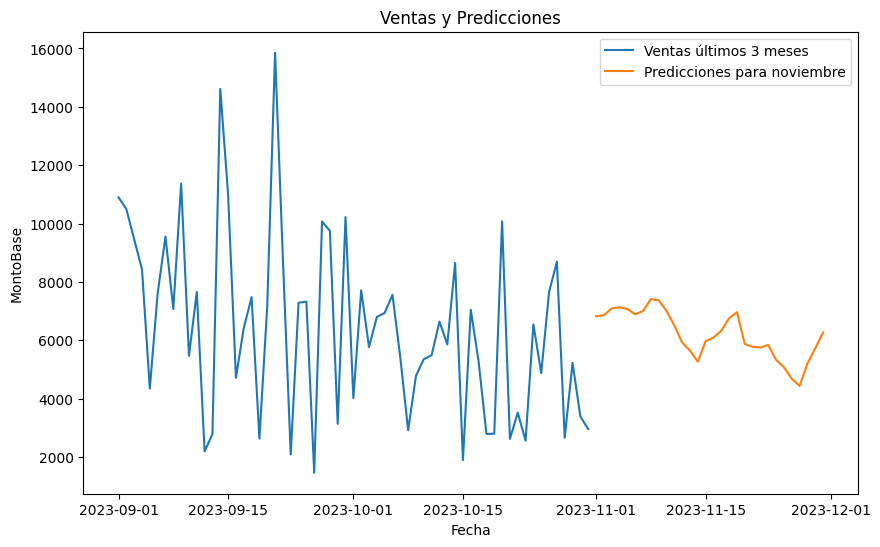

In [50]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

# Supongamos que df_lstm_sin_2020 tiene la columna 'FechaMovimiento' como índice
df_lstm_sin_2020.index = pd.to_datetime(df_lstm_sin_2020.index)

# Paso 1: Preparar datos de entrada para las predicciones
last_3_months = df_lstm_sin_2020[df_lstm_sin_2020.index >= '2023-09-01']  # Ajusta la fecha según tu necesidad
input_data = last_3_months['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences(input_data, seq_length)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Paso 2: Hacer predicciones para los siguientes 30 días
predictions_2_future = model_2.predict(input_data)

# Desnormalizar las predicciones
predictions_2_future = scaler.inverse_transform(predictions_2_future)

# Paso 3: Visualizar los resultados
plt.figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plt.plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_2_future))
plt.plot(dates_future, predictions_2_future, label='Predicciones para noviembre')

plt.title('Ventas y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('MontoBase')
plt.legend()
plt.show()

### Evaluar

In [51]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_suma_sin_2020['Ventas_LSTM'] = predictions_2_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  4462.3058       6767.3108    6162.8828
1       2023-11-02  8102.9741       7314.8346    6483.5054
2       2023-11-03  7202.3021       9272.4877    6897.1533
3       2023-11-04  7468.0628       7889.3505    6985.0259
4       2023-11-05  4232.6536       5544.5831    6799.6948
5       2023-11-06  2994.0749       6436.9181    6435.5767
6       2023-11-07  3876.1407       7203.7810    6387.0767
7       2023-11-08  5228.0023       6835.5754    6699.1777
8       2023-11-09  6858.0460       7330.5173    6728.2056
9       2023-11-10  5662.3457       9236.0115    6352.9175
10      2023-11-11  3842.8728       7802.3071    5799.1196
11      2023-11-12  5791.7782       5409.6706    5103.9419
12      2023-11-13  5310.8120       6257.8539    4752.3149
13      2023-11-14  2437.4624       6985.1935    4546.6108
14      2023-11-15  6755.3347       6582.8769    5279.9849
15      2023-11-16  8146.9736       7049.7622    5608.63

In [52]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:-
MSE is : 2737667.5119764977
MAE is : 1415.3513227994795
R2 is : 0.001555706723167516 %
------------------------------
RMSE is : 1654.5898319452158
MAPE is : 32.86720059165147 %
------------------------------


# ARIMA

In [53]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.2 MB/s eta 0:00:00


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from pmdarima.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [55]:
df_todo_hasta_nov_prophet.head()

,ds,y
0,2018-11-01,1475.2840
1,2018-11-02,2284.0240
2,2018-11-03,2621.9550
3,2018-11-04,4610.9490
4,2018-11-05,2468.8390


## CON 2020

In [56]:
df_arima = df_todo_hasta_nov_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })


# Establecer la columna 'FechaMovimiento' como índice
df_arima.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

print(df_arima.dtypes)
print(df_arima.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2018-11-01       1475.2840
2018-11-02       2284.0240
2018-11-03       2621.9550
2018-11-04       4610.9490
2018-11-05       2468.8390
...                    ...
2023-10-27       8692.4340
2023-10-28       2662.3572
2023-10-29       5225.2595
2023-10-30       3387.6399
2023-10-31       2956.2879

[1717 rows x 1 columns]>


In [57]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1717 entries, 2018-11-01 to 2023-10-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MontoBase  1717 non-null   float64
dtypes: float64(1)
memory usage: 26.8+ KB


### Identificar si los datos son estacionarios o no


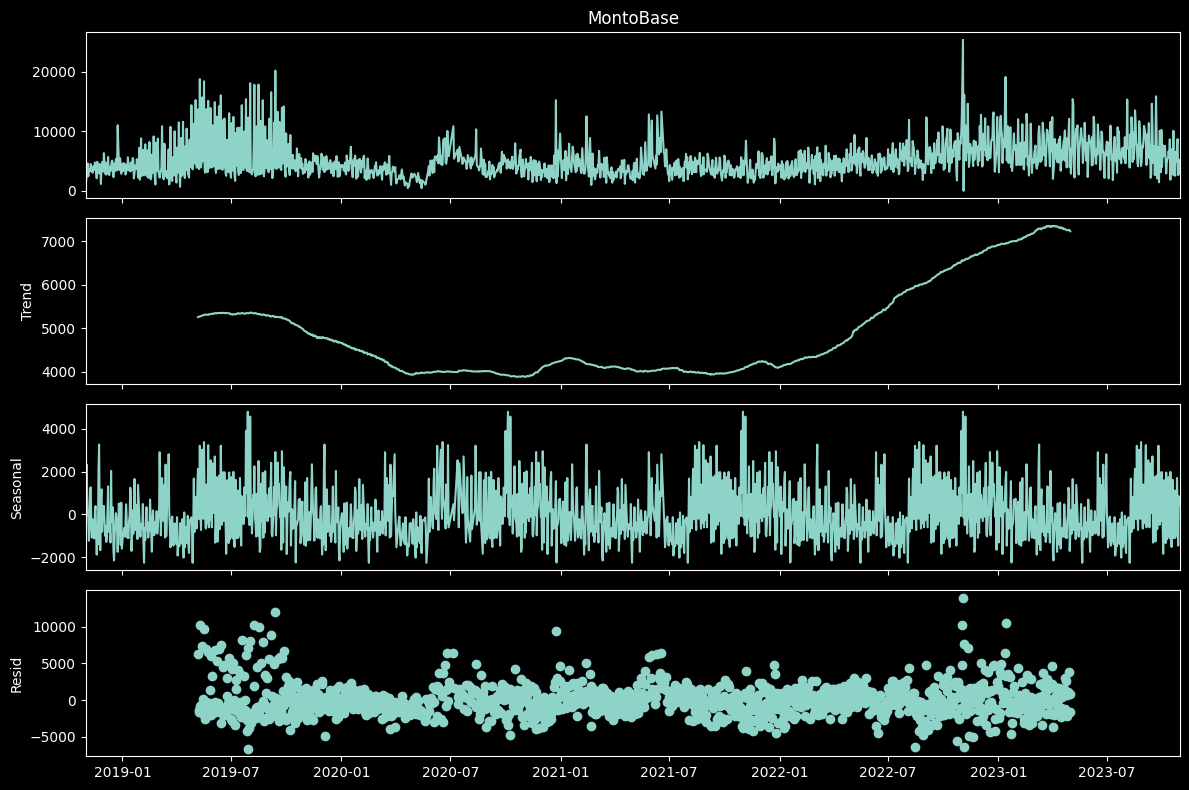

In [58]:
#plt.style.use('seaborn')
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima["MontoBase"], model = "add", period=365)
a.plot();

In [59]:
df_arima

,MontoBase
FechaMovimiento,
2018-11-01,1475.2840
2018-11-02,2284.0240
2018-11-03,2621.9550
2018-11-04,4610.9490
2018-11-05,2468.8390
...,...
2023-10-27,8692.4340
2023-10-28,2662.3572
2023-10-29,5225.2595


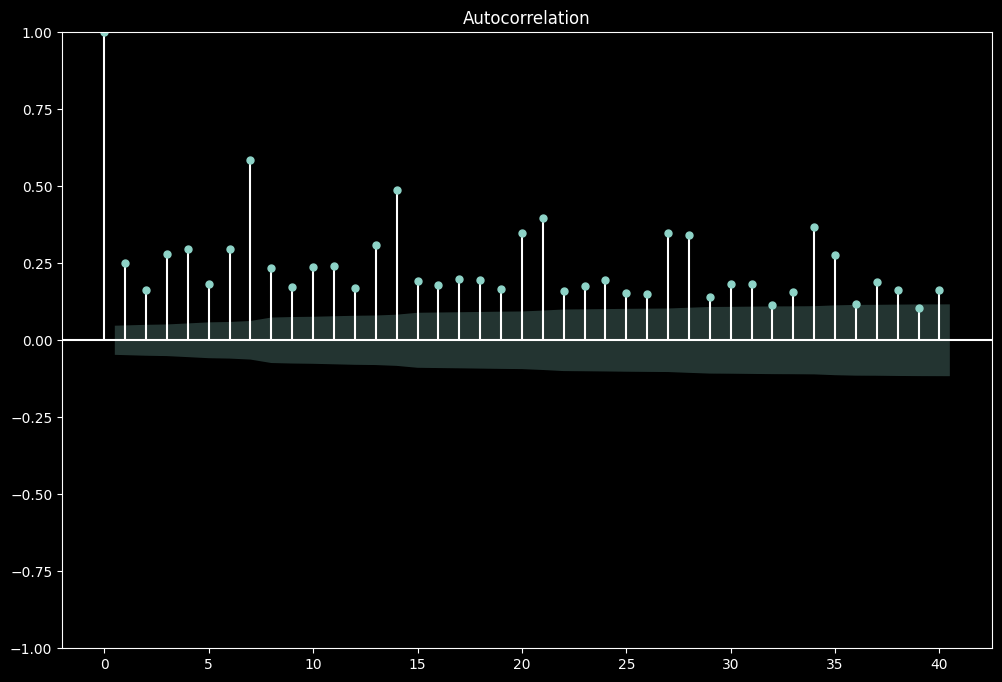

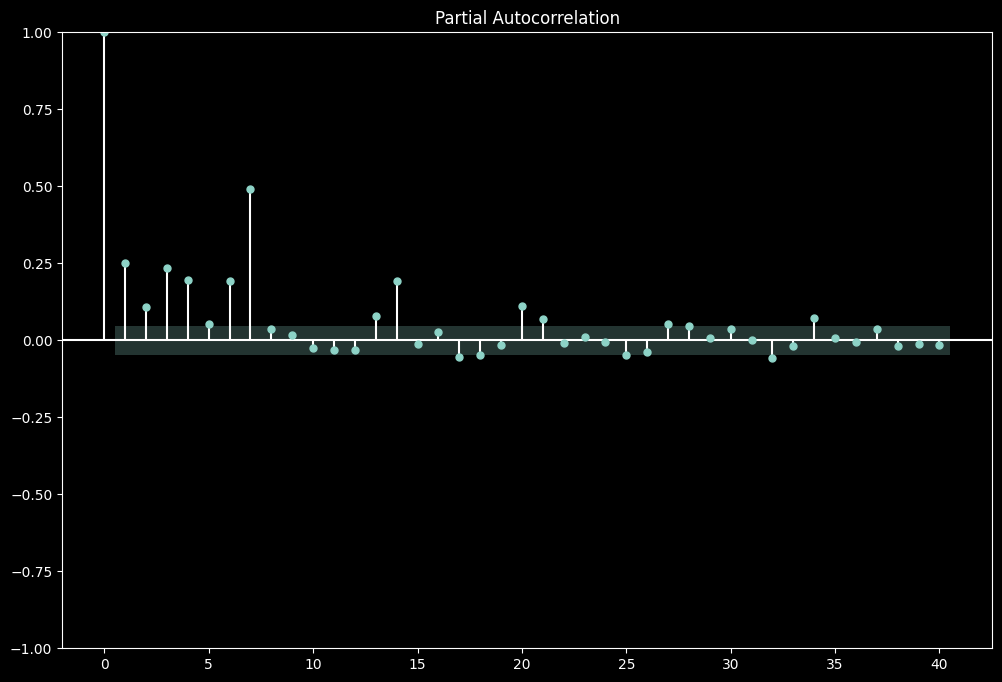

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# Dejar la columna 'FechaMovimiento' como tipo fecha
df_arima=df_arima.reset_index()

# Convertir 'FechaMovimiento' a tipo datetime si aún no lo has hecho
df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_arima.set_index('FechaMovimiento', inplace=True)

# Visualizar ACF y PACF
plt.style.use('dark_background')
plot_acf(df_arima['MontoBase'], lags=40)
plt.show()

plot_pacf(df_arima['MontoBase'], lags=40)
plt.show()

### prueba de Dickey-Fuller

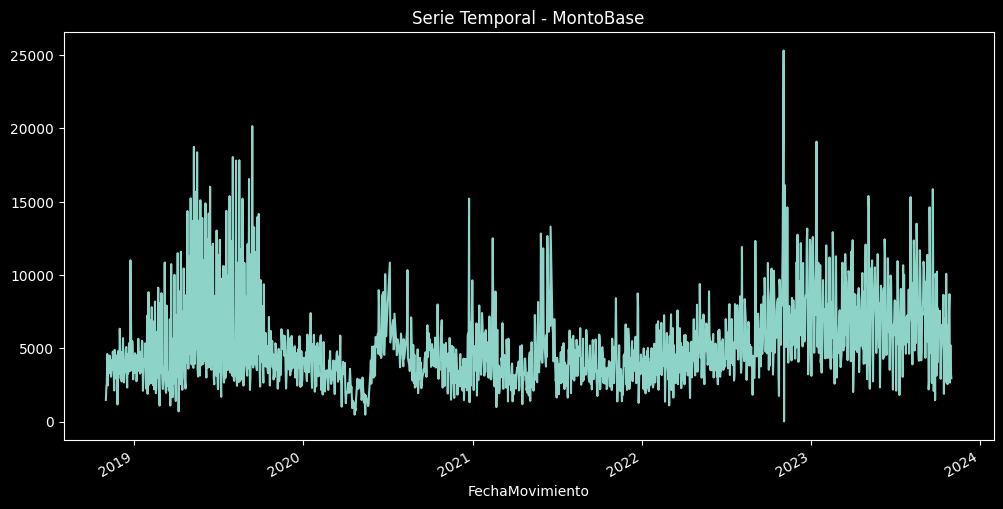

count    1717.0000
mean     5123.8273
std      2860.9934
min        11.1872
25%      3235.0670
50%      4398.6670
75%      6083.5753
max     25309.9626
Name: MontoBase, dtype: float64
Estadística de la prueba de Dickey-Fuller: -3.3939169304860943
P-valor: 0.011167999265218996
Valores críticos: {'1%': -3.4342115713566796, '5%': -2.863245666499036, '10%': -2.567678052034198}


In [61]:
# 1. Visualización de la Serie Temporal
df_arima['MontoBase'].plot(figsize=(12, 6))
plt.title('Serie Temporal - MontoBase')
plt.show()

# 2. Estadísticas Descriptivas
print(df_arima['MontoBase'].describe())

# 3. Prueba de Dickey-Fuller
result = adfuller(df_arima['MontoBase'])
print(f'Estadística de la prueba de Dickey-Fuller: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos: {result[4]}')

In [62]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [63]:
Prueba_Dickey_Fuller(df_arima["MontoBase"],"MontoBase")

Resultados de la prueba de Dickey-Fuller para columna: MontoBase
Test Statistic                         -3.3939
p-value                                 0.0112
No Lags Used                           20.0000
Número de observaciones utilizadas   1696.0000
Critical Value (1%)                    -3.4342
Critical Value (5%)                    -2.8632
Critical Value (10%)                   -2.5677
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


### Dividir en train y test

In [64]:
# # dividir en orden cronologico, un 80% para entrenamiento
# train_size = int(len(df_arima) * 0.8)
# train, test = df_arima[0:train_size], df_arima[train_size:]


# dividir en orden cronologico, entrenando sin el mes de octubre
train_size = int(len(df_arima) - 31)
train, test = df_arima[0:train_size], df_arima[train_size:]

# Divide los datos en entrenamiento y prueba
# # Asegúrate de tener una columna de fecha (DatetimeIndex) en tu DataFrame
# y = df_arima['MontoBase']

# # Especifica el tamaño del conjunto de entrenamiento
# train_size = len(y) - 30

# # Divide los datos en entrenamiento y prueba
# train, test = train_test_split(y, train_size=train_size)


In [65]:
train.shape, test.shape

((1686, 1), (31, 1))

### más pruebas


In [66]:
# display(df_arima.head(10))
# #df_arima = df_arima.set_index('FechaMovimiento')
# df_arima = df_arima.asfreq('D')
# display(df_arima.head(10))
# #df_arima = df_arima.asfreq(None)

In [67]:
print(df_arima.isnull().sum())

MontoBase    0
dtype: int64


In [68]:
df_arima = df_arima.dropna()

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -3.3939169304860943, p-value: 0.011167999265218996
KPSS Statistic: 2.2695297576256976, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -10.770294331966344, p-value: 2.393864576680593e-19
KPSS Statistic: 0.04586201046840822, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -18.574203384298364, p-value: 2.0810729049836947e-30
KPSS Statistic: 0.048110310507375534, p-value: 0.1


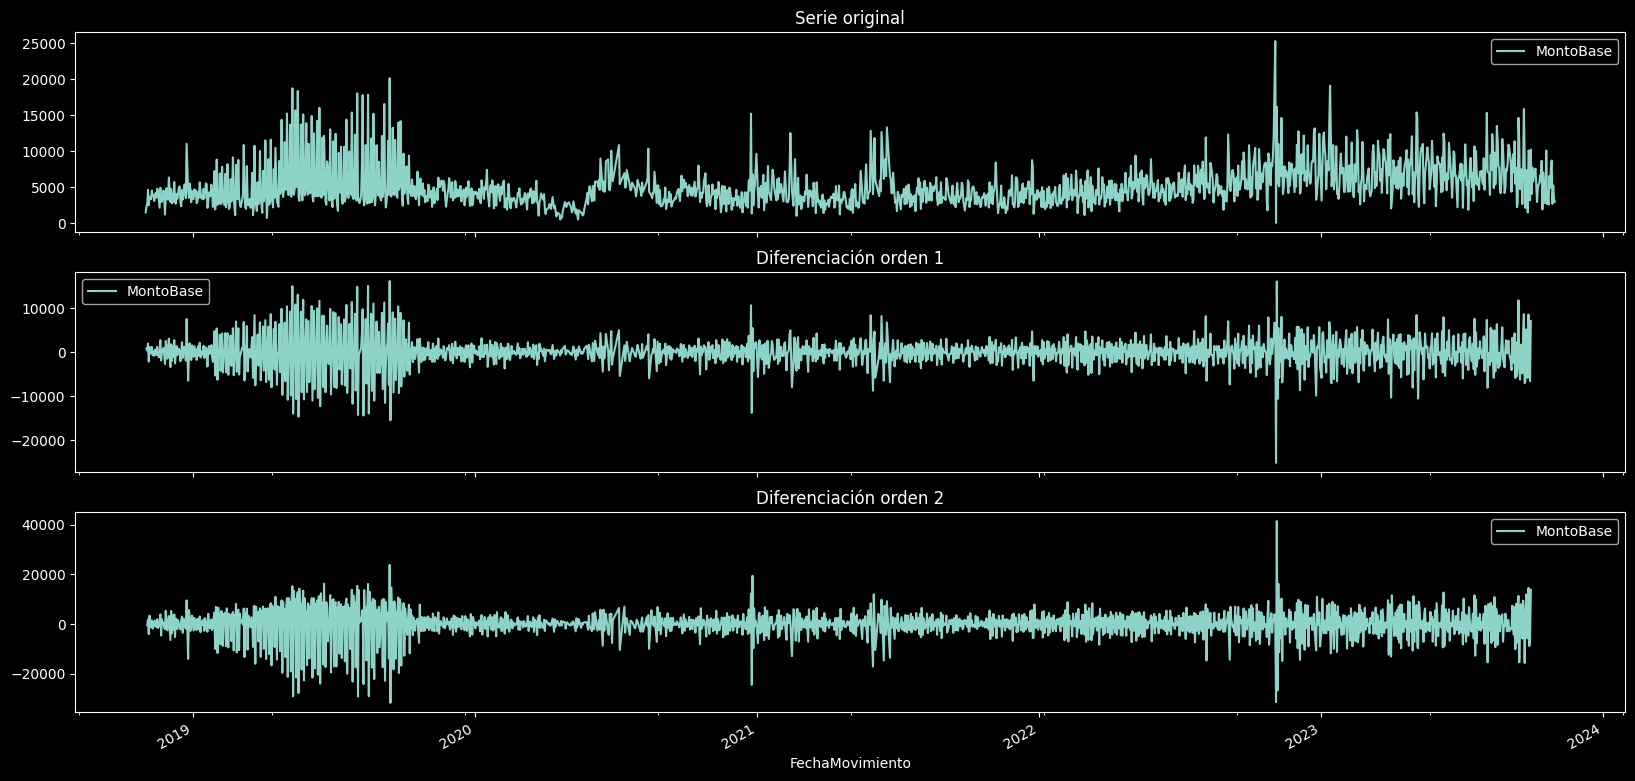

In [69]:

from statsmodels.tsa.stattools import kpss
import warnings
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

df_arima_diff_1 = train.diff().dropna()
df_arima_diff_2 = df_arima_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(df_arima)
kpss_result = kpss(df_arima)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_1)
kpss_result = kpss(df_arima.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_2)
kpss_result = kpss(df_arima.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)
df_arima.plot(ax=axs[0], title='Serie original')
df_arima_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
df_arima_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


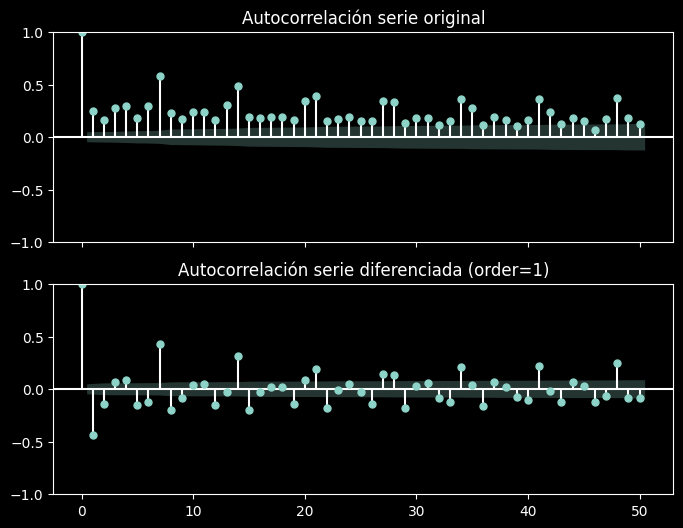

In [70]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
plot_acf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

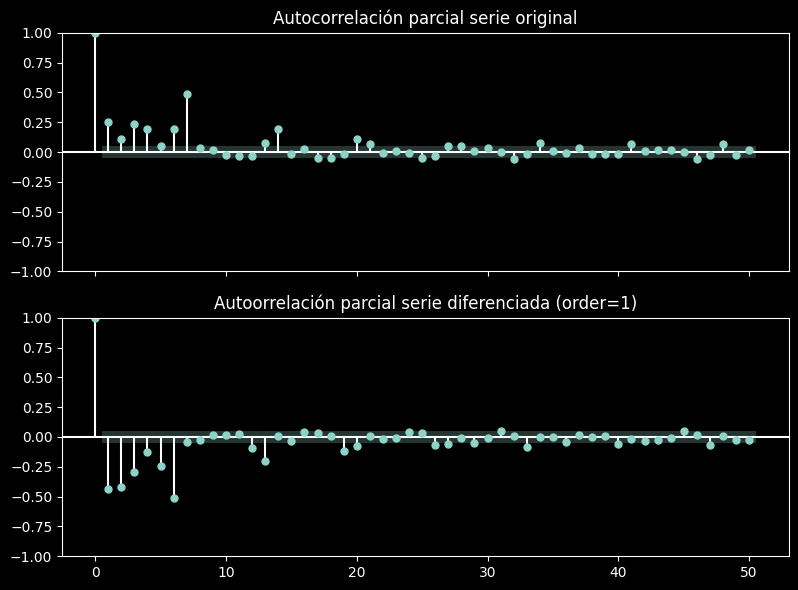

In [71]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
plot_pacf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

In [72]:
# # Asegurarse de que df_arima sea una serie temporal y no un DataFrame
# #df_arima = df_arima['MontoBase']

# # Descomposición de la serie original
# res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq', period=365)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
# # Descomposición de la serie original y la serie diferenciada
# # ==============================================================================
# #res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq')

# res_descompose_diff_2 = seasonal_decompose(df_arima_diff_1, model='additive', extrapolate_trend='freq', period=365)

# fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
# res_decompose.observed.plot(ax=axs[0, 0])
# axs[0, 0].set_title('Serie original')
# res_decompose.trend.plot(ax=axs[1, 0])
# axs[1, 0].set_title('Tendencia')
# res_decompose.seasonal.plot(ax=axs[2, 0])
# axs[2, 0].set_title('Estacionalidad')
# res_decompose.resid.plot(ax=axs[3, 0])
# axs[3, 0].set_title('Residuos')
# res_descompose_diff_2.observed.plot(ax=axs[0, 1])
# axs[0, 1].set_title('Series diferenciadas (order=1)')
# res_descompose_diff_2.trend.plot(ax=axs[1, 1])
# axs[1, 1].set_title('Tendencia')
# res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
# axs[2, 1].set_title('Estacionalidad')
# res_descompose_diff_2.resid.plot(ax=axs[3, 1])
# axs[3, 1].set_title('Residuos')
# fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
# fig.tight_layout();

In [74]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
df_arima_diff_1_12 = train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(df_arima_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(df_arima_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -13.04392717522121, p-value: 2.211810646839649e-24
KPSS Statistic: 0.020361218217052383, p-value: 0.1


### auto_arima


In [75]:
# Modelo Auto-Arima
from pmdarima import auto_arima

In [76]:
# posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
modelo_auto=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)
# ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=33444.926, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=32392.735, Time=10.94 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=14.66 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=33160.145, Time=0.33 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=32279.869, Time=28.68 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=25.72 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=6.60 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=32635.660, Time=2.47 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=32017.110, Time=22.79 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=32272.667, Time=2.67 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=45.47 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=12.91 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=31946.363, Time=10.38 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=32141.511, Time=3.28 sec
 ARIMA(3,1,0)(2,1,1)[12]   

In [77]:
# print(modelo_auto.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1686
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 12)   Log Likelihood              -15911.710
Date:                            Thu, 22 Feb 2024   AIC                          31837.420
Time:                                    18:40:56   BIC                          31875.377
Sample:                                         0   HQIC                         31851.483
                                           - 1686                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8053      0.019    -43.496      0.000      -0.842      -0.769
ar.L2         -0.7408      0.023   

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### implementación del modelo

In [78]:
print(train)

                 MontoBase
FechaMovimiento           
2018-11-01       1475.2840
2018-11-02       2284.0240
2018-11-03       2621.9550
2018-11-04       4610.9490
2018-11-05       2468.8390
...                    ...
2023-09-26       1460.5152
2023-09-27      10070.7077
2023-09-28       9750.2390
2023-09-29       3135.7638
2023-09-30      10221.7752

[1686 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<ipython-input-80-a09ff01a70ab>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


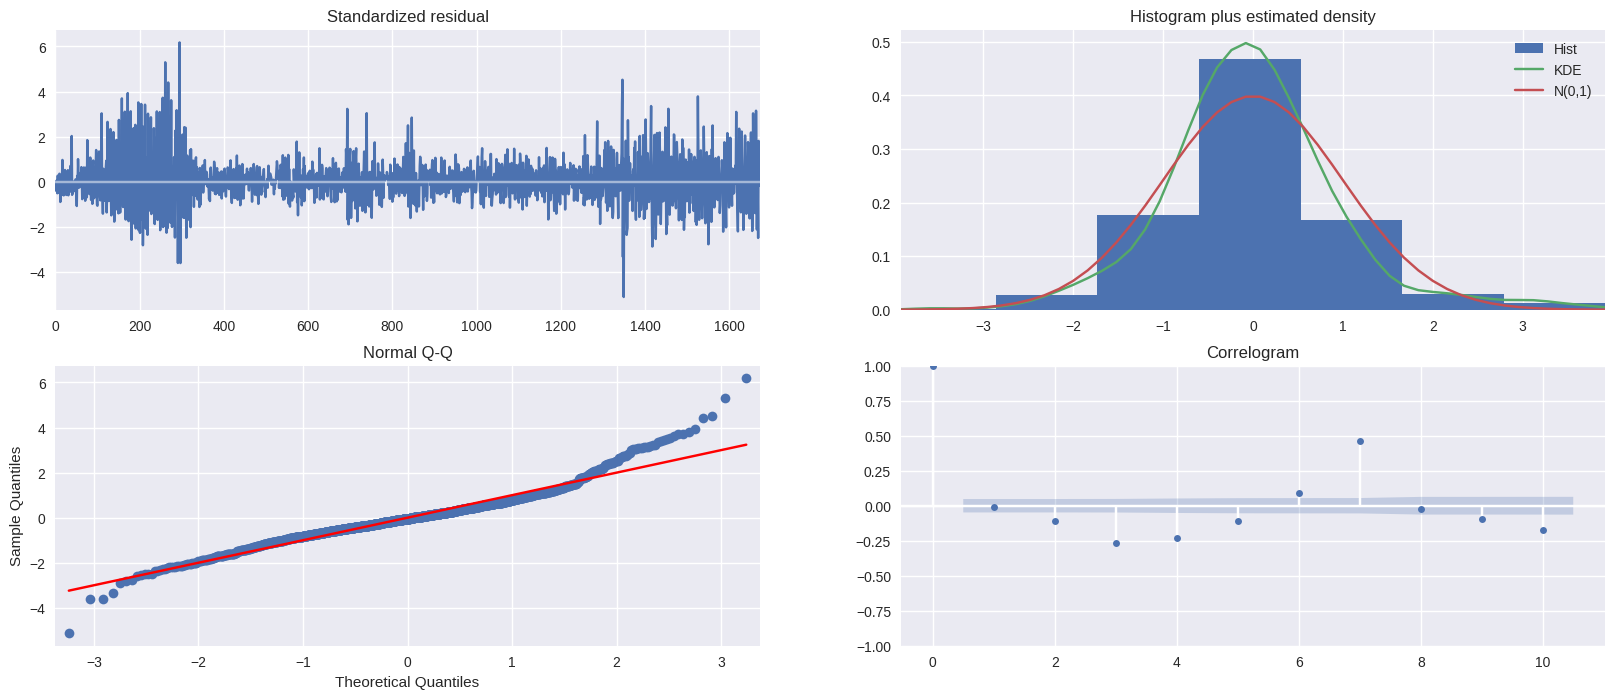

In [80]:
plt.style.use('seaborn')
modelo_auto.plot_diagnostics(figsize=(20,8))
plt.show()

In [81]:
# primera sucursal
# arima_model = SARIMAX(train["MontoBase"], order = (3,1,1), seasonal_order = (2,1,0,12))
# segunda sucursal
# arima_model = SARIMAX(train["MontoBase"], order = (4,1,1), seasonal_order = (2,1,0,12))
# tercera sucursal
arima_model = SARIMAX(train["MontoBase"], order = (4,1,0), seasonal_order = (2,1,0,12))
arima_result = arima_model.fit()
warnings.filterwarnings("default")
arima_result.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          MontoBase   No. Observations:                 1686
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 12)   Log Likelihood              -15911.710
Date:                            Thu, 22 Feb 2024   AIC                          31837.420
Time:                                    18:45:34   BIC                          31875.377
Sample:                                         0   HQIC                         31851.483
                                           - 1686                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8053      0.019    -43.496      0.000      -0.842      -0.769
ar.L2         -0.7408      0.023    -31.851      0.000      -0.786      -0.695
ar.L3         -0.3648      0.024    -15.505      0.000      -0.411      -0.319
ar.L4         -0.0465      0.021     -2.220      0.026      -0.087      -0.005
ar.S.L12      -0.5976      0.021    -27.805      0.000      -0.640      -0.555
ar.S.L24      -0.4195      0.020    -21.221      0.000      -0.458      -0.381
sigma2      1.066e+07   2.32e+05     46.058      0.000    1.02e+07    1.11e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               929.53
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.68
Prob(H) (two-sided):                  0.68   Kurtosis:                         6.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.79e+14. Standard errors may be unstable.
"""

### Pruebas de modelos ARIMA pero diferentes

In [82]:
# # Modelo SARIMAX con statsmodels.Sarimax
# # ==============================================================================
# warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
# modelo = SARIMAX(endog = train["MontoBase"], order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
# modelo_res = modelo.fit(disp=0)
# warnings.filterwarnings("default")
# modelo_res.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
# import statsmodels as sm
# # Esta es la forma del modelo, para utilizar menos memoria y un nuevo metodo
# # mod = sm.tsa.arima.ARIMA(endog, order=(p, d, q), seasonal_order=(P, D, Q, 365))
# # res = mod.fit(method='innovations_mle', low_memory=True, cov_type='none')
# mod = sm.tsa.arima.model.ARIMA(train["MontoBase"], order=(3, 1, 1), seasonal_order=(2, 1, 0, 12))
# res = mod.fit(method='innovations_mle', low_memory=True)
# warnings.filterwarnings("default")
# res.summary()

Cómo interpretar las gráficas de residuos en el modelo ARIMA


In [84]:
arima_pred = arima_result.predict(start = len(train), end = len(df_arima)-1, typ="levels").rename("ARIMA_Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


1686    8906.0834
1687    8293.0147
1688   10161.2126
1689    7483.3451
1690    6549.5903
1691    7053.2850
1692    7534.3976
1693    8669.4007
1694   11305.1802
1695    9033.1656
1696    4993.6793
1697    9484.9100
1698    8877.7267
1699    8356.6052
1700   12483.2168
1701    7686.8334
1702    7022.3999
1703    5851.7373
1704    6309.3689
1705   10688.5331
1706   11754.6323
1707    8150.2603
1708    6065.2635
1709    9578.3799
1710    7064.5859
1711    8651.0379
1712   14288.4514
1713    8911.6354
1714    5671.5721
1715    7471.0326
1716    7758.0201
Name: ARIMA_Predictions, dtype: float64

In [85]:
arima_pred.index = test.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred)

FechaMovimiento
2023-10-01    8906.0834
2023-10-02    8293.0147
2023-10-03   10161.2126
2023-10-04    7483.3451
2023-10-05    6549.5903
2023-10-06    7053.2850
2023-10-07    7534.3976
2023-10-08    8669.4007
2023-10-09   11305.1802
2023-10-10    9033.1656
2023-10-11    4993.6793
2023-10-12    9484.9100
2023-10-13    8877.7267
2023-10-14    8356.6052
2023-10-15   12483.2168
2023-10-16    7686.8334
2023-10-17    7022.3999
2023-10-18    5851.7373
2023-10-19    6309.3689
2023-10-20   10688.5331
2023-10-21   11754.6323
2023-10-22    8150.2603
2023-10-23    6065.2635
2023-10-24    9578.3799
2023-10-25    7064.5859
2023-10-26    8651.0379
2023-10-27   14288.4514
2023-10-28    8911.6354
2023-10-29    5671.5721
2023-10-30    7471.0326
2023-10-31    7758.0201
Name: ARIMA_Predictions, dtype: float64


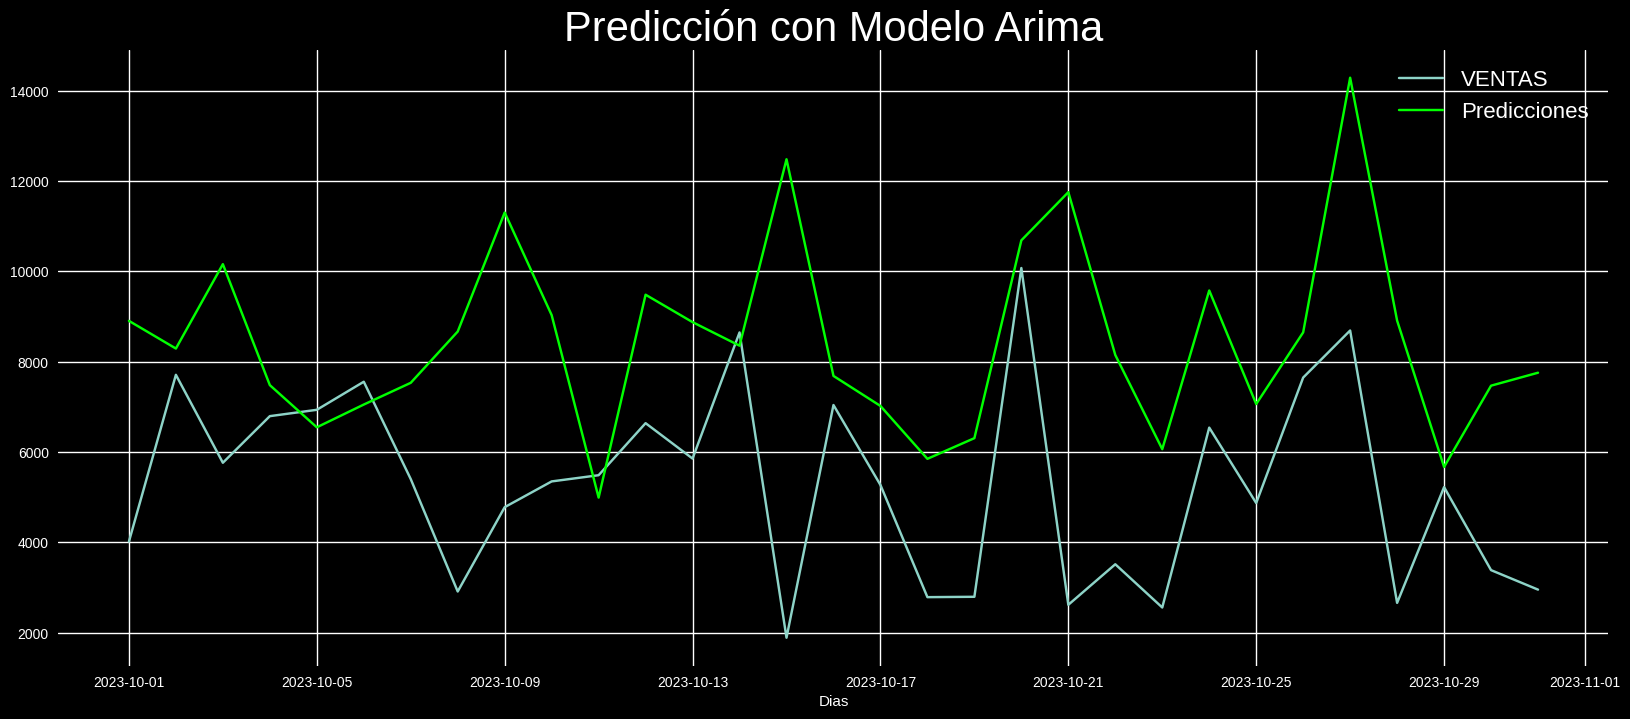

In [86]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test["MontoBase"], label="VENTAS")
plt.plot(arima_pred, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Dias')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [87]:
arima_pred2 = arima_result.predict(start = 1699,end=1728, typ="levels").rename("ARIMA Predictions")
arima_pred2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ty

1699    8356.6052
1700   12483.2168
1701    7686.8334
1702    7022.3999
1703    5851.7373
1704    6309.3689
1705   10688.5331
1706   11754.6323
1707    8150.2603
1708    6065.2635
1709    9578.3799
1710    7064.5859
1711    8651.0379
1712   14288.4514
1713    8911.6354
1714    5671.5721
1715    7471.0326
1716    7758.0201
1717    7261.4121
1718   11771.8165
1719    9782.4681
1720    5449.2552
1721   10635.3591
1722    8963.7229
1723    9252.1635
1724   13039.2919
1725    8898.0614
1726    7084.2056
1727    7811.1561
1728    8209.9645
Name: ARIMA Predictions, dtype: float64

In [88]:
print(df_noviembre_sumaT.head())
#df_noviembre_sumaT.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_sumaT.head())

  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  4462.3058       6767.3108    6162.8828
1      2023-11-02  8102.9741       7314.8346    6483.5054
2      2023-11-03  7202.3021       9272.4877    6897.1533
3      2023-11-04  7468.0628       7889.3505    6985.0259
4      2023-11-05  4232.6536       5544.5831    6799.6948
  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  4462.3058       6767.3108    6162.8828
1      2023-11-02  8102.9741       7314.8346    6483.5054
2      2023-11-03  7202.3021       9272.4877    6897.1533
3      2023-11-04  7468.0628       7889.3505    6985.0259
4      2023-11-05  4232.6536       5544.5831    6799.6948


In [89]:
arima_pred2.index = df_noviembre_sumaT.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred2)

0     8356.6052
1    12483.2168
2     7686.8334
3     7022.3999
4     5851.7373
5     6309.3689
6    10688.5331
7    11754.6323
8     8150.2603
9     6065.2635
10    9578.3799
11    7064.5859
12    8651.0379
13   14288.4514
14    8911.6354
15    5671.5721
16    7471.0326
17    7758.0201
18    7261.4121
19   11771.8165
20    9782.4681
21    5449.2552
22   10635.3591
23    8963.7229
24    9252.1635
25   13039.2919
26    8898.0614
27    7084.2056
28    7811.1561
29    8209.9645
Name: ARIMA Predictions, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<ipython-input-90-2a97b7cdadf6>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


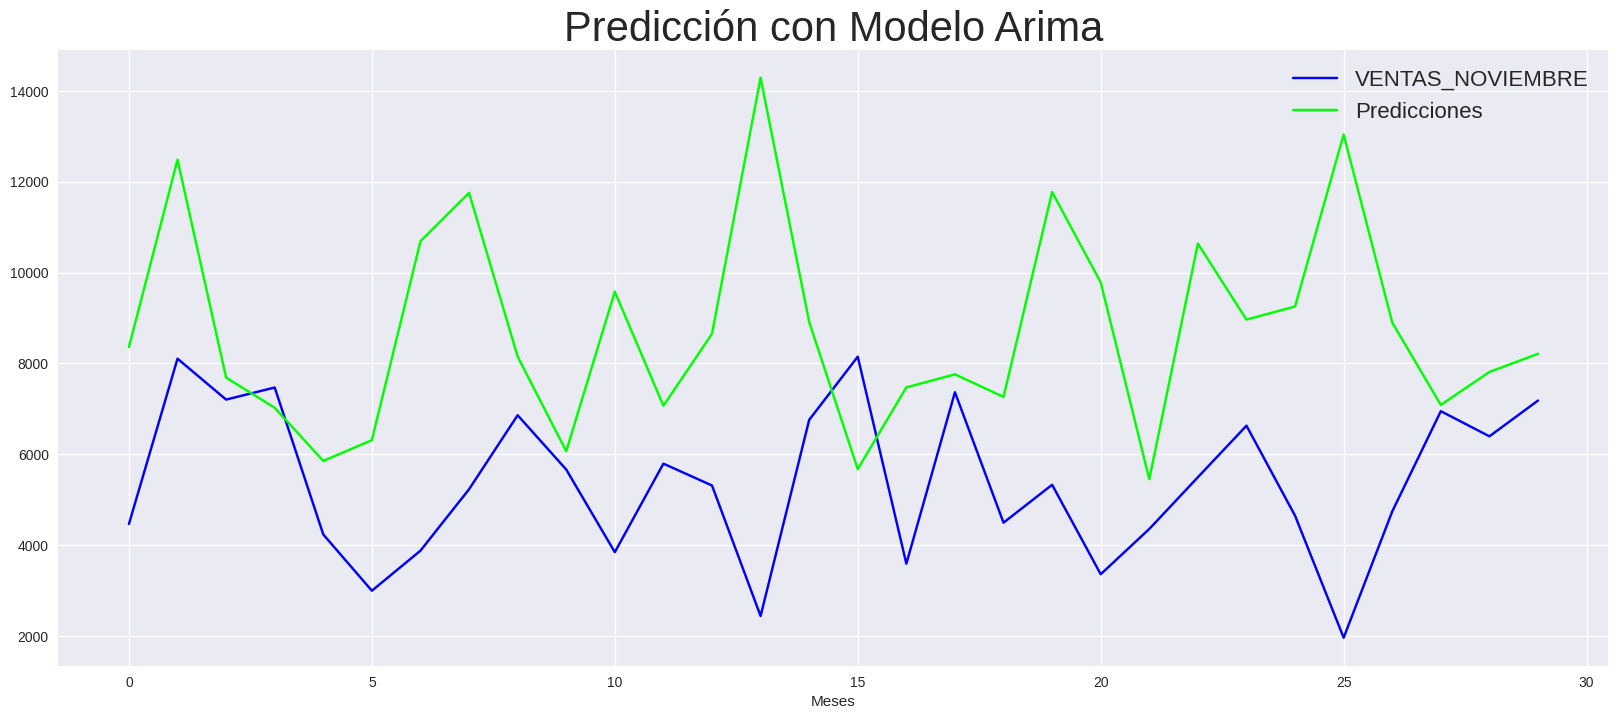

In [90]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

#plt.plot(test["MontoBase"],color="blue" ,label="VENTAS")
plt.plot(df_noviembre_sumaT["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plt.plot(arima_pred2, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Evaluar


In [91]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_ARIMA'] = arima_pred2

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0       2023-11-01  4462.3058       6767.3108    6162.8828     8356.6052
1       2023-11-02  8102.9741       7314.8346    6483.5054    12483.2168
2       2023-11-03  7202.3021       9272.4877    6897.1533     7686.8334
3       2023-11-04  7468.0628       7889.3505    6985.0259     7022.3999
4       2023-11-05  4232.6536       5544.5831    6799.6948     5851.7373
5       2023-11-06  2994.0749       6436.9181    6435.5767     6309.3689
6       2023-11-07  3876.1407       7203.7810    6387.0767    10688.5331
7       2023-11-08  5228.0023       6835.5754    6699.1777    11754.6323
8       2023-11-09  6858.0460       7330.5173    6728.2056     8150.2603
9       2023-11-10  5662.3457       9236.0115    6352.9175     6065.2635
10      2023-11-11  3842.8728       7802.3071    5799.1196     9578.3799
11      2023-11-12  5791.7782       5409.6706    5103.9419     7064.5859
12      2023-11-13  5310.8120       6257.8539    47

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])

Evaluation metric results:-
MSE is : 21310237.165472873
MAE is : 3564.025664972498
R2 is : -6.771975447405941 %
------------------------------
RMSE is : 4616.301242929546
MAPE is : 94.81850660566658 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## SIN el 2020

In [93]:
df_arima_sin_2020 = df_todo_hasta_nov_sin_2020_prophet.rename(columns={
    'ds': 'FechaMovimiento',
    'y': 'MontoBase'
    })


# Establecer la columna 'FechaMovimiento' como índice
df_arima_sin_2020.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = pd.to_datetime(df_arima['FechaMovimiento'])

print(df_arima_sin_2020.dtypes)
print(df_arima_sin_2020.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2018-11-01       1475.2840
2018-11-02       2284.0240
2018-11-03       2621.9550
2018-11-04       4610.9490
2018-11-05       2468.8390
...                    ...
2023-10-27       8692.4340
2023-10-28       2662.3572
2023-10-29       5225.2595
2023-10-30       3387.6399
2023-10-31       2956.2879

[1417 rows x 1 columns]>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


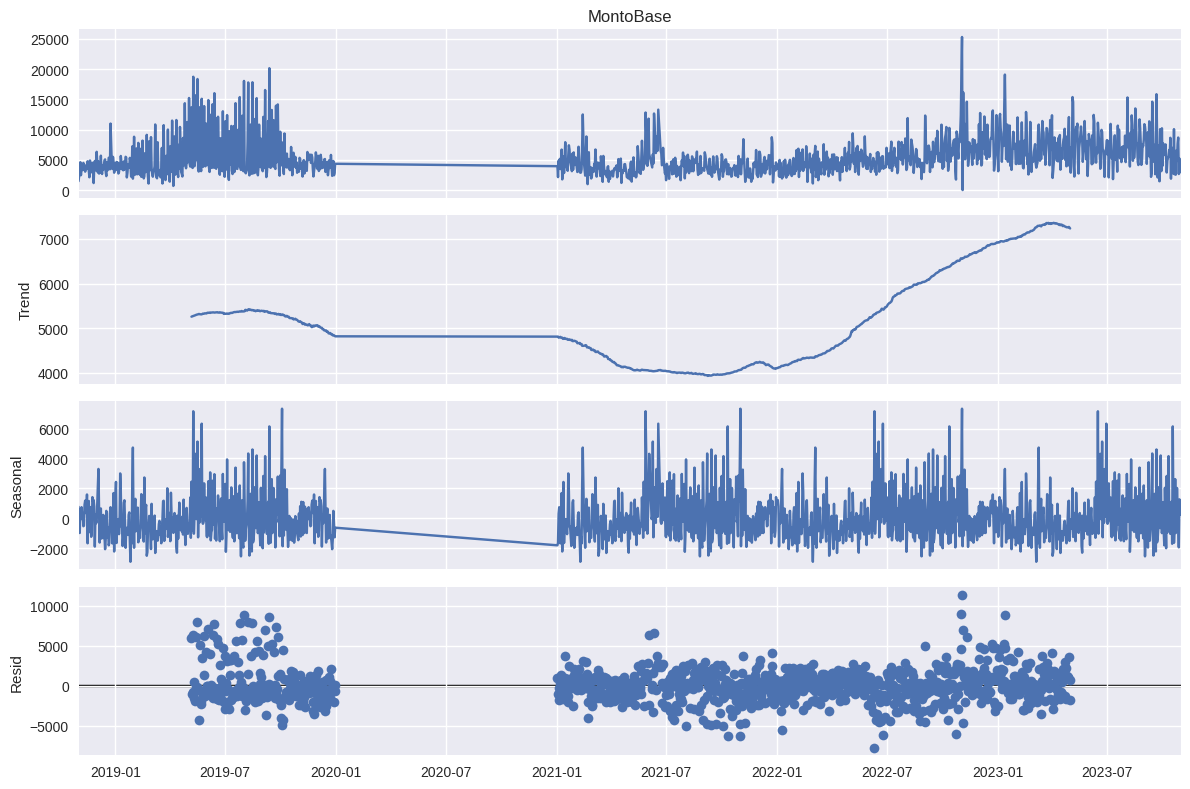

In [94]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima_sin_2020["MontoBase"], model = "add", period=365)
a.plot();

In [95]:
# dividir en orden cronologico, entrenando sin el mes de octubre
train_size_s20 = int(len(df_arima_sin_2020) - 31)
train_s20, test_s20 = df_arima_sin_2020[0:train_size_s20], df_arima_sin_2020[train_size_s20:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
train_s20.shape, test_s20.shape

((1386, 1), (31, 1))

In [97]:
print(train_s20)

                 MontoBase
FechaMovimiento           
2018-11-01       1475.2840
2018-11-02       2284.0240
2018-11-03       2621.9550
2018-11-04       4610.9490
2018-11-05       2468.8390
...                    ...
2023-09-26       1460.5152
2023-09-27      10070.7077
2023-09-28       9750.2390
2023-09-29       3135.7638
2023-09-30      10221.7752

[1386 rows x 1 columns]


In [98]:
arima_model_s20 = SARIMAX(train_s20["MontoBase"], order = (3,1,1), seasonal_order = (2,1,0,12))
arima_result_s20 = arima_model_s20.fit()
arima_result_s20.summary()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           MontoBase   No. Observations:                 1386
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood              -13019.171
Date:                             Thu, 22 Feb 2024   AIC                          26052.343
Time:                                     18:46:12   BIC                          26088.916
Sample:                                          0   HQIC                         26066.028
                                            - 1386                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0066      0.021      0.317      0.751      -0.034       0.047
ar.L2         -0.1625      0.022     -7.465      0.000      -0.205      -0.120
ar.L3          0.0639      0.021      3.075      0.002       0.023       0.105
ma.L1         -0.9994      0.009   -106.935      0.000      -1.018      -0.981
ar.S.L12      -0.6309      0.022    -28.114      0.000      -0.675      -0.587
ar.S.L24      -0.3214      0.024    -13.441      0.000      -0.368      -0.275
sigma2      1.001e+07    2.4e+05     41.760      0.000    9.54e+06    1.05e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1053.17
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             1.08
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.04e+14. Standard errors may be unstable.
"""

In [99]:

arima_pred_s20 = arima_result_s20.predict(start = 1381,end=1410, typ="levels").rename("ARIMA Predictions sin 2020")
arima_pred_s20


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ty

1381   10792.9399
1382    8662.1373
1383    7438.0838
1384    4922.0206
1385    8353.5613
1386    7959.1745
1387    6992.8756
1388   10754.1999
1389    6667.8450
1390    5621.5540
1391    5759.5756
1392    6316.0779
1393    8641.3054
1394   10563.3378
1395    7841.8670
1396    4614.0818
1397    8605.5285
1398    6897.3152
1399    7146.4163
1400   12604.3095
1401    7008.4431
1402    5256.4289
1403    5159.6837
1404    5566.5949
1405    8413.8372
1406   10621.6429
1407    7500.6198
1408    4810.2814
1409    8816.8625
1410    5928.1160
Name: ARIMA Predictions sin 2020, dtype: float64

In [100]:
arima_pred_s20.index = df_noviembre_suma_sin_2020.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred_s20)

0    10792.9399
1     8662.1373
2     7438.0838
3     4922.0206
4     8353.5613
5     7959.1745
6     6992.8756
7    10754.1999
8     6667.8450
9     5621.5540
10    5759.5756
11    6316.0779
12    8641.3054
13   10563.3378
14    7841.8670
15    4614.0818
16    8605.5285
17    6897.3152
18    7146.4163
19   12604.3095
20    7008.4431
21    5256.4289
22    5159.6837
23    5566.5949
24    8413.8372
25   10621.6429
26    7500.6198
27    4810.2814
28    8816.8625
29    5928.1160
Name: ARIMA Predictions sin 2020, dtype: float64


<ipython-input-101-05e78584d9d1>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  4462.3058       6562.2419    6821.5835
1      2023-11-02  8102.9741       7110.2903    6857.6260
2      2023-11-03  7202.3021       9370.8507    7093.2944
3      2023-11-04  7468.0628       7698.7312    7132.4189
4      2023-11-05  4232.6536       5260.5752    7071.8081
  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0      2023-11-01  4462.3058       6562.2419    6821.5835
1      2023-11-02  8102.9741       7110.2903    6857.6260
2      2023-11-03  7202.3021       9370.8507    7093.2944
3      2023-11-04  7468.0628       7698.7312    7132.4189
4      2023-11-05  4232.6536       5260.5752    7071.8081


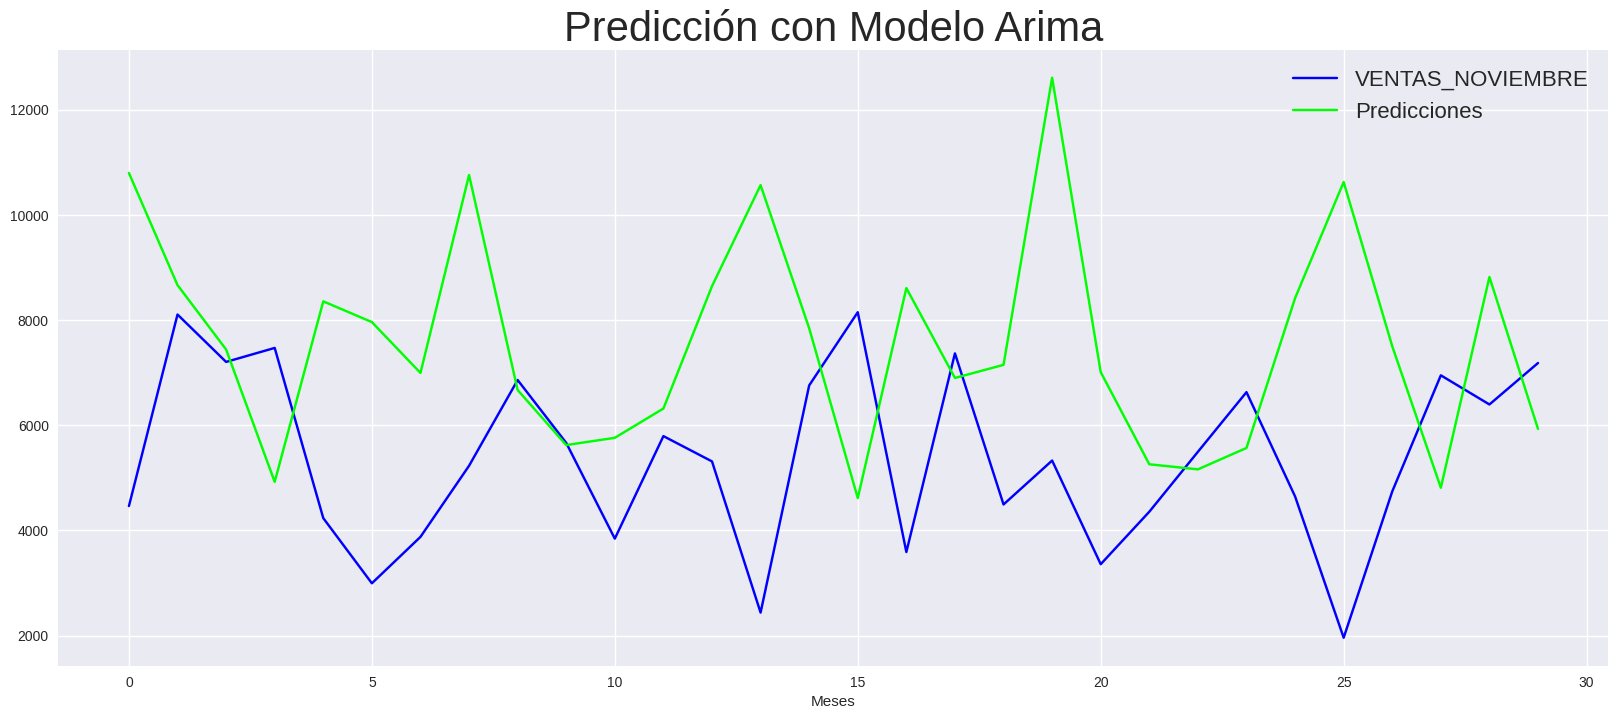

In [101]:
print(df_noviembre_suma_sin_2020.head())
#df_noviembre_suma_sin_2020.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_suma_sin_2020.head())

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)
#plt.plot(test_s20["MontoBase"],color="blue" ,label="VENTAS")
plt.plot(df_noviembre_suma_sin_2020["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plt.plot(arima_pred_s20, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

## Evaluar

In [102]:
# PARA ELIMINAR LA COLUMNA CON VALORES 'NaN'
# print(df_noviembre_suma_sin_2020)
# df_noviembre_suma_sin_2020.drop(columns=['Ventas_ARIMA'], inplace=True)
print(df_noviembre_suma_sin_2020)

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  4462.3058       6562.2419    6821.5835
1       2023-11-02  8102.9741       7110.2903    6857.6260
2       2023-11-03  7202.3021       9370.8507    7093.2944
3       2023-11-04  7468.0628       7698.7312    7132.4189
4       2023-11-05  4232.6536       5260.5752    7071.8081
5       2023-11-06  2994.0749       6049.3674    6887.7471
6       2023-11-07  3876.1407       6976.0248    7003.5557
7       2023-11-08  5228.0023       6566.2572    7409.0620
8       2023-11-09  6858.0460       7055.8932    7367.6167
9       2023-11-10  5662.3457       9260.5922    7006.8901
10      2023-11-11  3842.8728       7536.4184    6507.4971
11      2023-11-12  5791.7782       5051.1485    5923.5586
12      2023-11-13  5310.8120       5798.7520    5646.0181
13      2023-11-14  2437.4624       6690.9614    5267.0112
14      2023-11-15  6755.3347       6254.1165    5966.8496
15      2023-11-16  8146.9736       6724.4794    6091.59

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_suma_sin_2020['Ventas_ARIMA'] = arima_pred_s20

# Imprimir el resultado
print(df_noviembre_suma_sin_2020.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0       2023-11-01  4462.3058       6562.2419    6821.5835    10792.9399
1       2023-11-02  8102.9741       7110.2903    6857.6260     8662.1373
2       2023-11-03  7202.3021       9370.8507    7093.2944     7438.0838
3       2023-11-04  7468.0628       7698.7312    7132.4189     4922.0206
4       2023-11-05  4232.6536       5260.5752    7071.8081     8353.5613
5       2023-11-06  2994.0749       6049.3674    6887.7471     7959.1745
6       2023-11-07  3876.1407       6976.0248    7003.5557     6992.8756
7       2023-11-08  5228.0023       6566.2572    7409.0620    10754.1999
8       2023-11-09  6858.0460       7055.8932    7367.6167     6667.8450
9       2023-11-10  5662.3457       9260.5922    7006.8901     5621.5540
10      2023-11-11  3842.8728       7536.4184    6507.4971     5759.5756
11      2023-11-12  5791.7782       5051.1485    5923.5586     6316.0779
12      2023-11-13  5310.8120       5798.7520    56

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_ARIMA'])

Evaluation metric results:-
MSE is : 14440813.695517695
MAE is : 2950.562586020508
R2 is : -4.266654172388537 %
------------------------------
RMSE is : 3800.1070636914556
MAPE is : 77.14512254140715 %
------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## TODAS LAS EVALUACIONES

In [105]:
print("--"*10,"EVALUACIÓN CON 2020","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])
print("--"*10,"EVALUACIÓN SIN 2020","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_suma_sin_2020['MontoBase'],df_noviembre_suma_sin_2020['Ventas_ARIMA'])

-------------------- EVALUACIÓN CON 2020 --------------------
---------- PROPHET ----------
Evaluation metric results:-
MSE is : 5194874.530542092
MAE is : 1775.2011151021725
R2 is : -0.894602907993103 %
------------------------------
RMSE is : 2279.2267396075567
MAPE is : 45.758223365531215 %
------------------------------
---------- LSTM ----------
Evaluation metric results:-
MSE is : 2737667.5119764977
MAE is : 1415.3513227994795
R2 is : 0.001555706723167516 %
------------------------------
RMSE is : 1654.5898319452158
MAPE is : 32.86720059165147 %
------------------------------
---------- ARIMA ----------
Evaluation metric results:-
MSE is : 21310237.165472873
MAE is : 3564.025664972498
R2 is : -6.771975447405941 %
------------------------------
RMSE is : 4616.301242929546
MAPE is : 94.81850660566658 %
------------------------------
-------------------- EVALUACIÓN SIN 2020 --------------------
---------- PROPHET ----------
Evaluation metric results:-
MSE is : 4636677.215003964
MAE 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###Graficas de todas las Predicciones

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-106-0fc22ac8dbf5>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


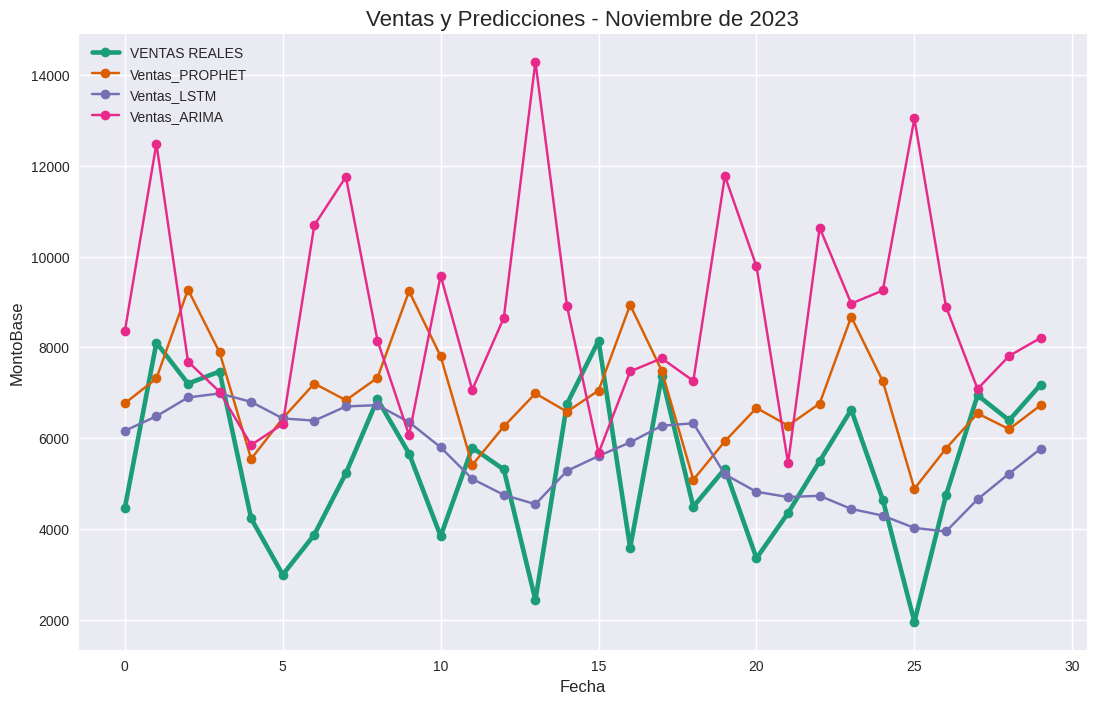

In [106]:
# Establecer el estilo de Seaborn
plt.style.use('seaborn')
sns.set_palette("Dark2")

# Graficar los datos para df_noviembre_sumaT
plt.figure(figsize=(13, 8))
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plt.plot(df_noviembre_sumaT.index, df_noviembre_sumaT['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
plt.title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('MontoBase', fontsize=12)
plt.legend()
plt.savefig('ventas_predicciones_sumaT.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-107-85d2d79c9e93>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


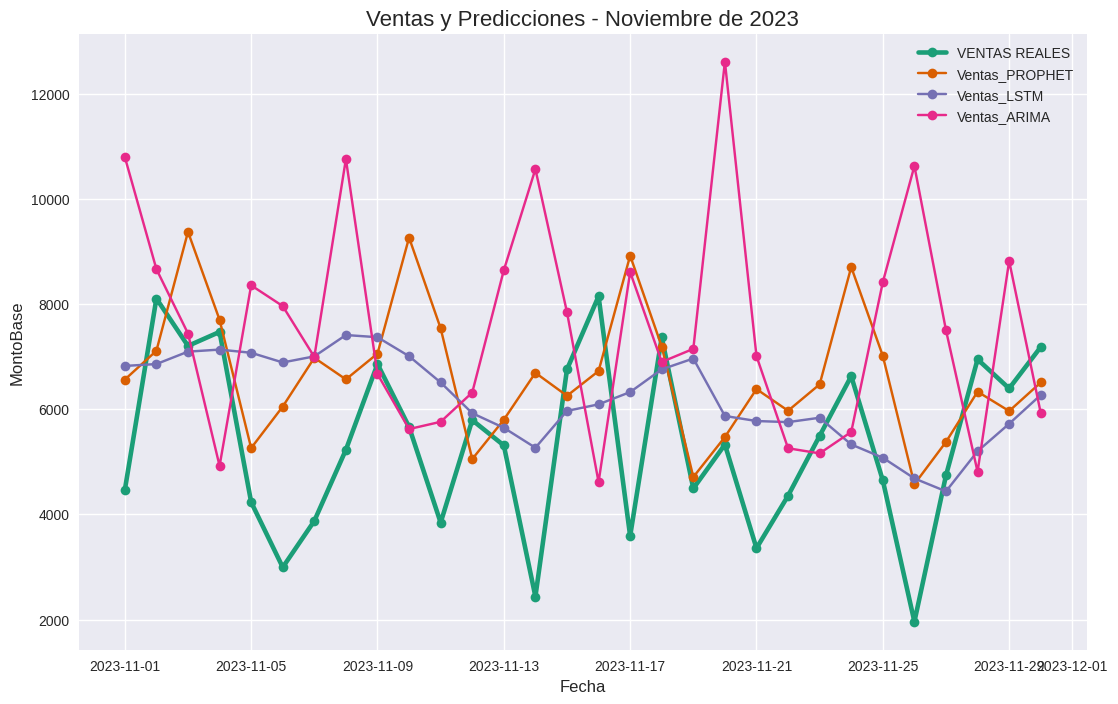

In [107]:
# Establecer el estilo de Seaborn
plt.style.use('seaborn')
sns.set_palette("Dark2")

# Graficar los datos para df_noviembre_suma_sin_2020
plt.figure(figsize=(13, 8))
plt.plot(df_noviembre_suma_sin_2020['FechaMovimiento'], df_noviembre_suma_sin_2020['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plt.plot(df_noviembre_suma_sin_2020['FechaMovimiento'], df_noviembre_suma_sin_2020['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plt.plot(df_noviembre_suma_sin_2020['FechaMovimiento'], df_noviembre_suma_sin_2020['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plt.plot(df_noviembre_suma_sin_2020['FechaMovimiento'], df_noviembre_suma_sin_2020['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
plt.title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('MontoBase', fontsize=12)
plt.legend()
plt.savefig('ventas_predicciones_sin_2020.png')
plt.show()